In [48]:
#reloads any packages before importing
%load_ext autoreload
%autoreload 2

# Numpy imports:
import numpy as np

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

import cv2

# for extracting filenames
import glob

# skimage submodules we need
import skimage.io
import skimage.measure
import skimage.filters
import skimage.exposure
import skimage.morphology
from skimage.registration import phase_cross_correlation

#Matplotlib imports
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# # Seaborn imports (stylistic for nice plots)
# import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
#     'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
# sns.set(style='ticks', rc=rc)

#for DataFrames
import pandas as pd

#To interact with the operating system
import os

#For status bar 
from tqdm.notebook import tqdm as tqdm

#Custom packages
import atp_cal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
atp_cal.pboc_style_mpl()

# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'

# Functions

In [3]:
def fit_bivariate_quadratic(image):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    image (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Get image dimensions
    M, N = image.shape

    # Create a meshgrid of coordinates
    i = np.arange(M)
    j = np.arange(N)
    I, J = np.meshgrid(i, j, indexing='ij')

    # Flatten the matrices for the least squares fitting
    I_flat = I.flatten()
    J_flat = J.flatten()
    Z_flat = image.flatten()

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly(image):
    """ Evaluates best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic(image);
    I, J = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted

def evBivPoly(image):
    """Finds evened image"""
    im_biv = evaluateBivPoly(image)
    alpha = np.nanmean(im_biv)/im_biv
    image_ev = image*alpha
    return image_ev

In [4]:
def quickGridDivide(test_im, n_rows, n_cols):
    """ Computes mean & standard deviation of local blocks of test_im, in a coarse grid of size n_rows x n_cols. 
    The grid size must be evenly divisable by the image dimensions. If not, an error will specify whether the rows
    or columns are not evenly divisable by the image
    
    Params:
    test_im: 2D array-like
             the inputted image you wish to divide
    n_rows:  integer
             the number of grid rows
    n_cols:  integer
             the number of grid columns
             
    Returns:
    test_means: 2D array-like
                an image the shape of test_im, where each pixel in a given grid block has the mean intensity value of the grid block
    test_stds:  2D array-like
                an image the shape of test_im, where each pixel in a given grid block has the standard deviaiton value of the grid block
    """
    
    #ensure the image is converted to a 64 bit float
    test_im=test_im.astype('float64')
    
    # Check that the image is evenly divisable by inputted rows and cols
    mod_row = test_im.shape[0]%n_rows
    mod_col = test_im.shape[1]%n_cols
    
    if mod_row != 0:
        raise ValueError("Image shape is not divisible by inputted n_rows.")
    if mod_col != 0:
        raise ValueError("Image shape is not divisible by inputted n_cols.")
    
    
    # preallocate arrays the shape of test_im to input mean and stds
    test_means = np.zeros_like(test_im)
    test_stds = np.zeros_like(test_im)
    
    # Find the number of pixels in each grid block row/column
    pxperrow, pxpercol = test_im.shape[0]//n_rows,  test_im.shape[1]//n_cols
    
    #Find the mean and standard deviation of each grid block
    for i in range(n_rows):
        for j in range(n_cols):
            crop = np.s_[i*pxperrow:(i+1)*pxperrow, j*pxpercol:(j+1)*pxpercol]
            test_crop = test_im[crop]

            test_means[crop]+=np.nanmean(test_crop)
            test_stds[crop]+=np.nanstd(test_crop)
        
    return test_means, test_stds

In [5]:
def varsources(im, blo_means, blo_stds, n_rows, n_cols):
    """
    perform the grid binning using the quickGridDivide function. Then find the variation within grid blocks, between grid blocks, or the total over all pixels.
    
    Params:
    im: 2D array-like
             the inputted image you wish to divide
    n_rows:  integer
             the number of grid rows
    n_cols:  integer
             the number of grid columns
             
    Returns:
    blo_means: 2D array-like
               an image the shape of test_im, where each pixel in a given grid block has the mean intensity value of the grid block
    blo_stds:  2D array-like
               an image the shape of test_im, where each pixel in a given grid block has the standard deviaiton value of the grid block
    var_tot:   float
               variation of all pixels in the image
    var_in:    float
               average of the variation within a grid block over all grid blocks
    var_btwn:  float
               variation between the means of grid blocks
               
    """
#     #instantiate arrays
#     blo_means = np.zeros_like(im, dtype=np.float64)
#     blo_stds = np.zeros_like(im, dtype=np.float64)

#     #compute block means and stds
#     BlockMeans, BlockStds = quickGridDivide(im.astype('float64'), n_rows=n_rows, n_cols=n_cols)
#     blo_means += BlockMeans
#     blo_stds += BlockStds

    #find total, inside and between variances
    var_tot = np.nanstd(im)**2
    var_in = np.average(blo_stds**2)
    var_btwn = np.average((blo_means - np.average(im))**2)

    return var_tot, var_in, var_btwn

In [6]:
def blovar_for_arr(ATPconc, image_array, num_rows, num_cols):
    
    blo_means_arr = np.zeros_like(image_array, dtype=np.float64)
    blo_stds_arr = np.zeros_like(image_array, dtype=np.float64)
    
    var_tot_arr = np.zeros_like(ATPconc, dtype=np.float64)
    var_in_arr = np.zeros_like(ATPconc, dtype=np.float64)
    var_btwn_arr = np.zeros_like(ATPconc, dtype=np.float64)

    for i, ATP in enumerate(tqdm(ATPconc)):
        image = image_array[i]
        blo_means, blo_stds = quickGridDivide(image.astype('float64'), n_rows=num_rows, n_cols=num_cols)
        var_tot, var_in, var_btwn = varsources(image, blo_means, blo_stds, num_rows, num_cols)
        
        blo_means_arr[i] += blo_means
        blo_stds_arr[i] += blo_stds
        var_tot_arr[i] += var_tot
        var_in_arr[i] += var_in
        var_btwn_arr[i] += var_btwn
        
    df = pd.DataFrame({'ATPconc': ATPconc,
                       'var_tot_arr': var_tot_arr,
                       'var_in_arr':var_in_arr,
                       'var_btwn_arr':var_btwn_arr, 
                      })
    
    # coord_x = np.arange(len(image)/(2*num_rows), len(image), len(image)/num_rows)
    # coord_y = np.arange(len(image[0])/(2*num_cols), len(image[0]), len(image[0])/num_cols)
    # coord = np.array([coord_x, coord_y])

    return df, blo_means_arr, blo_stds_arr #, coord


In [7]:
def centcoords(image, num_rows, num_cols):
    coord_x = np.arange(len(image)/(2*num_rows), len(image), len(image)/num_rows)
    coord_y = np.arange(len(image[0])/(2*num_cols), len(image[0]), len(image[0])/num_cols)
    coord = np.array([coord_x, coord_y], dtype='object')
    return coord

def unique_blovals(arr, num_rows, num_cols):
    #Find the centers
    coords = centcoords(arr[0], num_rows, num_cols)
    
    #instantiate an array where each image will have the shape determined by the coordinates
    cent_arr = np.zeros((len(arr), len(coords[0]), len(coords[1]))) 
    
    #Find the value of each block's center
    for i, ival in enumerate(tqdm(coords[0])):
        for j, jval in enumerate(coords[1]):
            #assign the center of the block's value to the new array
            cent_arr[:,i,j] += arr[:,int(ival), int(jval)]

    return cent_arr

In [8]:
#If image size is constrained
def closest_square_length(inflec, common_sq, samp_im):
    #find the pixel square length common factors just below or above the infleciton point
    px_under = common_sq[np.where(common_sq<inflec)[0][-1]]
    px_over = common_sq[np.where(common_sq>inflec)[0][0]]

    #set the closest pixel square length to the inflection point as the box size to use
    if inflec-px_under < px_over-inflec:
        inflec_px = px_under
    else:
        inflec_px = px_over

    #define optimal rows and columns
    nrows=samp_im.shape[0]//inflec_px
    ncols=samp_im.shape[1]//inflec_px
    
    return inflec_px, nrows, ncols

#If image size is unconstrained, find crop
def closest_win_size(win_pref, inflec):
    #find the nearest multiple of the inflection point that gives a value closest to the desired win_size
    near_mult = round(win_pref/round(inflec))
    
    win_size = near_mult*round(inflec)
    ngridrows = near_mult*2
    
    return win_size, ngridrows

In [9]:
#Langmuir equation
def ATeam_Hill(conc, a, b, c):
    """
    Given a concentration value, this function returns an intensity value based on the Hill function given
    in Immamura et. al (ATeam paper)
    Parameters
    conc = 1D array of concentrations
    a, b, c, d parameters of the function
    
    Returns
    A 1D array of intensities corresponding to the given concentrations
    """
    
    
    
    return (((b-c)*(conc/a)/(1+(conc/a)))+c)



#Curve-fit to the Langmuir curve
def ATeam_Hill_curve_fit(conc, calavg, maxconc, p0, sigma=None, absolute_sigma=False, returncov=False):
    """
    Performs a curve fitting using scipy.optimize.curve_fit to fit data to a Langmuir curve
    
    Parameters
    conc = 1D array of concentrations
    calavg = 1D array of average intensity values of data
    maxconc = scalar Maximum concentration of data taken
    p0 = 1D list with 4 entries of parameter guesses for a, b, c, and d in the Hill function
    
    Returns
    param = 1D list with fit values of each parameter
    curve = 1D array of intensity values for every concentration in xvals
    xvals = 1D array from 0 to maxconc with step size 1
    """
    
    
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(ATeam_Hill, 
                                 conc, 
                                 calavg, 
                                 p0, 
                                 sigma,
                                 absolute_sigma,
                                 bounds = (np.zeros(3), np.ones([3])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxconc,maxconc)
    curve = ATeam_Hill(xvals, param[0], param[1], param[2])
    
    if returncov==True:
        return param, param_cov, curve, xvals
    else:
        return param, curve, xvals

## Import Images

In [10]:
#This should not change between experiments:
datapath = '../../data/atp_cal'

#This varies between experiments. 
datafolder = '2023-12-16_A81D_Cal' #EDIT THIS EVERY TIME

# bound Images
included_bound = '*uM*/*Pos*/*405*.tif' #EDIT THIS EVERY TIME
bound_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_bound))

# unbound Images
included_unbound = '*uM*/*Pos*/*480*.tif' #EDIT THIS EVERY TIME
unbound_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_unbound))

#Find the ATP concentrations of each image
ATPconc_unsrt=[]
for i, file in enumerate(unbound_files):
    conc = int(file.split('/')[5].split('_')[0].split('uM')[0]) #EDIT THIS EVERY TIME
    ATPconc_unsrt.append(conc)
ATPconc_unsrt = np.array(ATPconc_unsrt)

#Find the indeces to sort the ATP concnetrations and reorder
sorted_indices = np.argsort(ATPconc_unsrt)
ATPconc=ATPconc_unsrt[sorted_indices]

#Read in images and save as array:
bound_array_unsrt = atp_cal.file_to_image(bound_files)
unbound_array_unsrt = atp_cal.file_to_image(unbound_files)

#Sort the images
bound_array=bound_array_unsrt[sorted_indices]
unbound_array=unbound_array_unsrt[sorted_indices]

# Set background - want a no ATeam image for this
bound_bg = 1915
unbound_bg = 1915


# Define the zero concentration image (DO EVERY TIME):
bound_zero = np.average(bound_array[np.where(ATPconc==0)], axis=0)
unbound_zero = np.average(unbound_array[np.where(ATPconc==0)], axis=0)

# Dark Camera Image Subtraction
## Examine Dark Images
Import dark images (camera shutter closed)

In [11]:
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
dark_files = np.sort(glob.glob(file_path_dark))
dark_ims = atp_cal.file_to_image(dark_files)
dark_avg = np.average(dark_ims, axis=0)
dark_std = np.nanstd(dark_ims, axis=0)

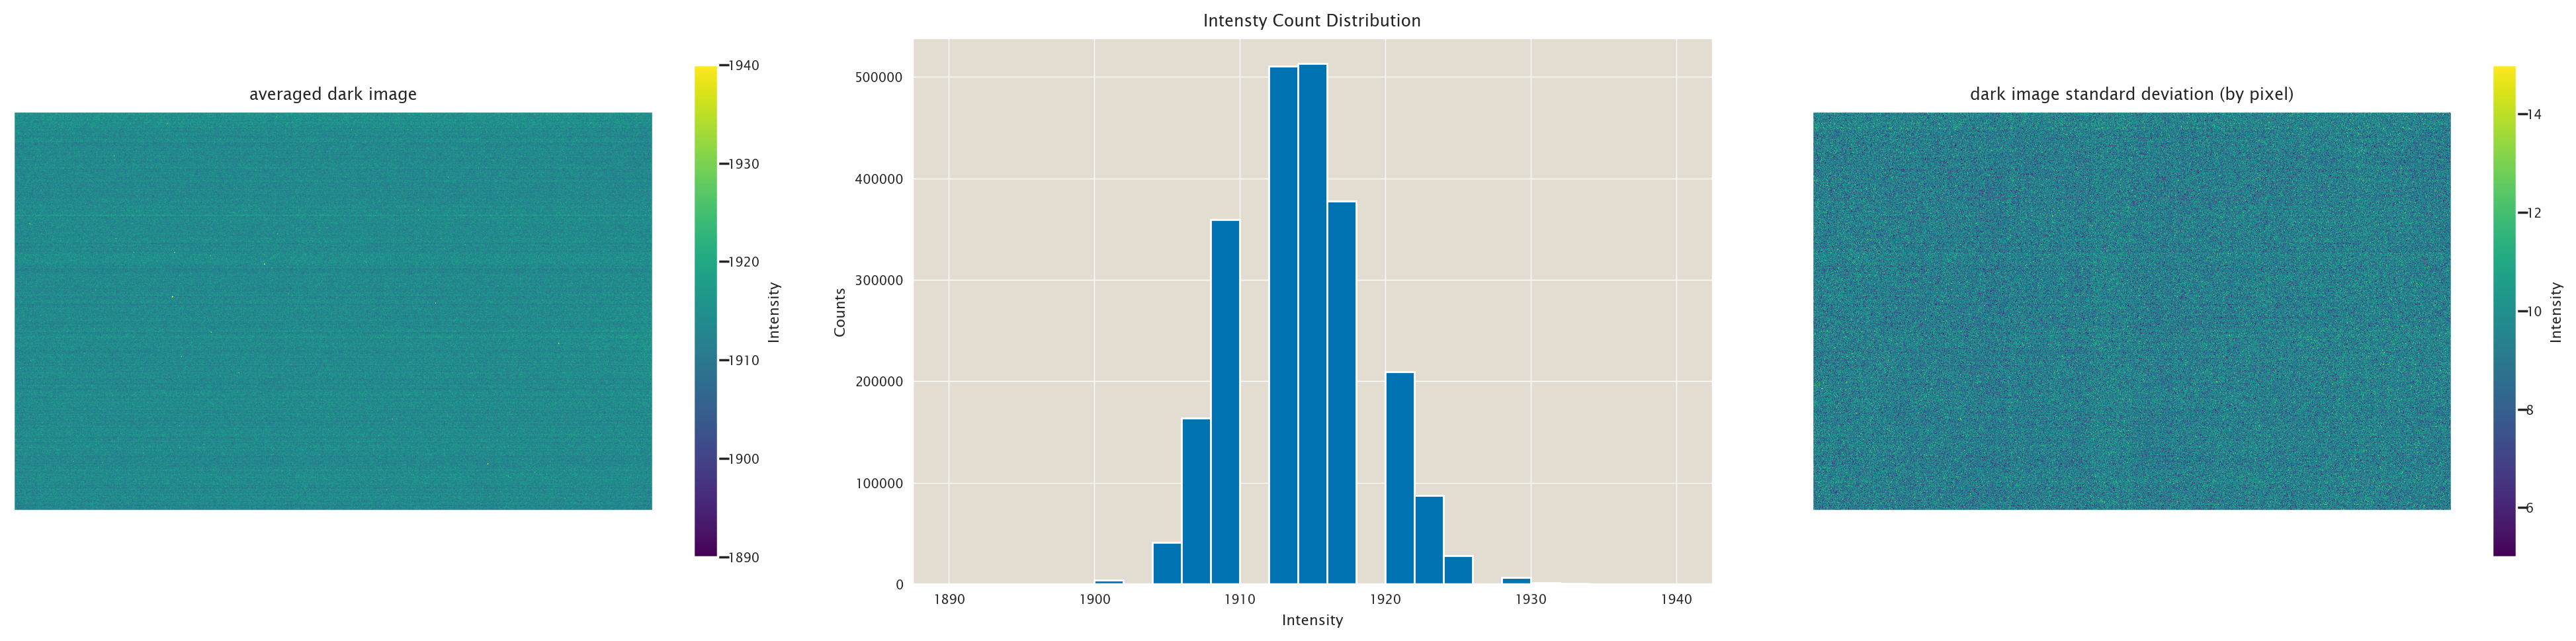

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax0 = ax[0].imshow(dark_avg, vmin=1890, vmax=1940)
ax[0].grid(False)
fig.colorbar(ax0, ax=ax[0], shrink=0.9, label='Intensity')
ax[0].tick_params(labelbottom=False, labelleft=False)
ax[0].set_title('averaged dark image')

ax[1].hist(dark_avg.flatten(), bins=25, range=(1890, 1940))
ax[1].set_ylabel('Counts')
ax[1].set_xlabel('Intensity')
ax[1].set_title('Intensty Count Distribution')

ax2 = ax[2].imshow(dark_std, vmin=5, vmax=15)
ax[2].grid(False)
fig.colorbar(ax2, ax=ax[2], shrink=0.9, label='Intensity')
ax[2].tick_params(labelbottom=False, labelleft=False)
ax[2].set_title('dark image standard deviation (by pixel)')

fig.tight_layout()
#plt.savefig('../../data/dark_ims/dark_im_avg_fig', dpi = 400)

(array([4.23800e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.57556e+05,
        0.00000e+00, 9.29182e+05, 1.22852e+05, 2.99422e+05, 4.38551e+05,
        7.89100e+04, 7.14880e+04, 5.21270e+04, 4.69500e+03, 5.93300e+03,
        5.91000e+02, 1.57000e+02, 1.12000e+02, 1.30000e+01, 1.70000e+01,
        9.00000e+00, 3.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0.        ,  1.24850132,  2.49700265,  3.74550397,  4.9940053 ,
         6.24250662,  7.49100794,  8.73950927,  9.98801059, 11.23651191,
        12.48501324, 13.73351456, 14.98201589, 16.23051721, 17.47901853,
        18.72751986, 19.97602118, 21.2245225 , 22.47302383, 23.72152515,
        24.97002648, 26.2185278 , 27.46702912, 28.71553045, 29.96403177,
        31.2125331 ]),
 <BarContainer object of 25 artists>)

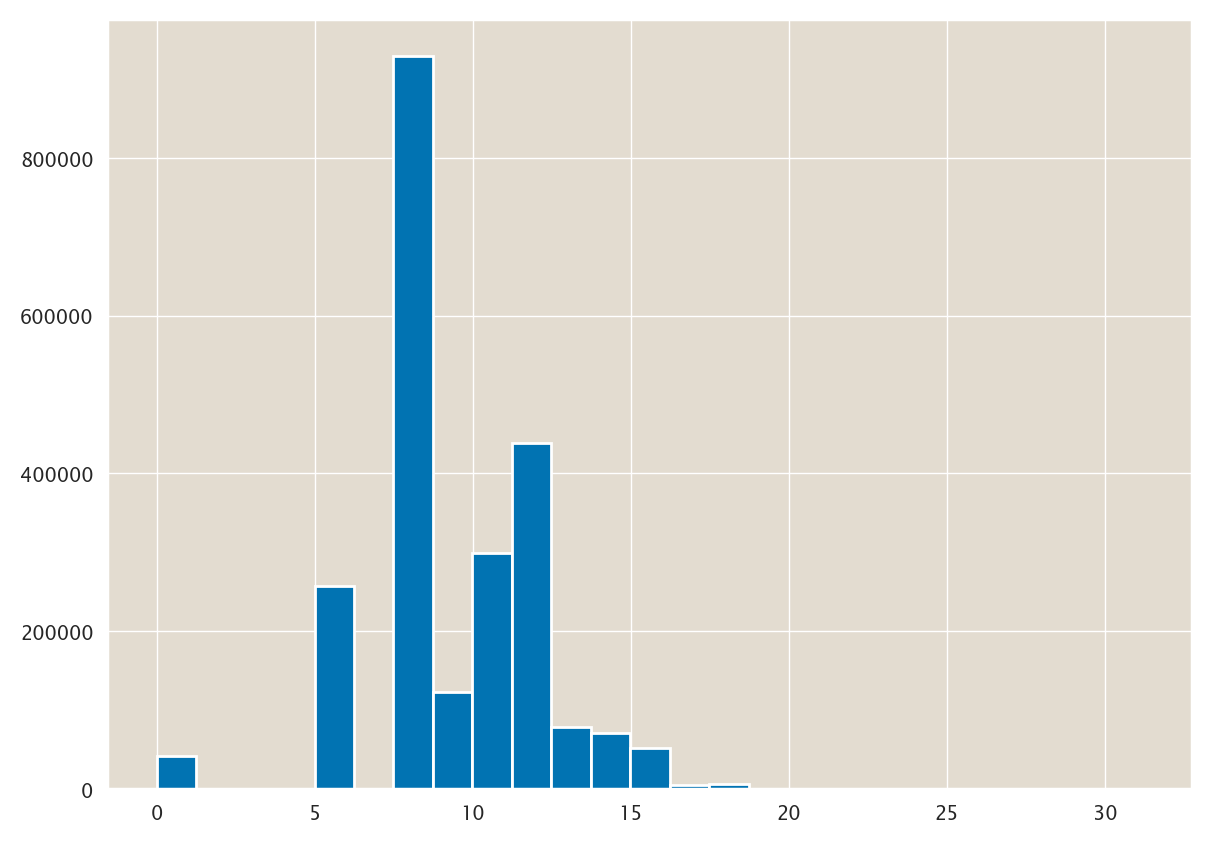

In [13]:
plt.hist(dark_std.flatten(), bins=25)

Do a quick check of the amount of variance inside vs between blocks in the dark image

In [14]:
dark_blo_means, dark_blo_stds = quickGridDivide(dark_avg, n_rows=80, n_cols=128)
dark_varsource = varsources(dark_avg, dark_blo_means, dark_blo_stds, n_rows=80, n_cols=128)
print(f'tot: {round(dark_varsource[0], 3)}, inside: {round(dark_varsource[1], 3)}, between: {round(dark_varsource[2], 3)}')

tot: 20.987, inside: 20.658, between: 0.329


## Subtract Dark Images

In [15]:
bound_bs = bound_array - dark_avg
unbound_bs = unbound_array - dark_avg

# Uneven Illumination Correction

## Blocking
We can see by eye there is a non-uniform gradient across images that should be homogeneous. This is a common microscopy feature where the light source does not evenly shine upon the sample. Here, we will first prove that the majority of variation in the image occurs over space, between regions of the image, rather than within given image regions. We will use this result to find a filter correction that removes spacial variation so all variation occurs within a given image region. 

First, we will write a function that segments an image into a grid and finds the mean intensity and standard deviation within each grid block.

Ok, let's see how the variance changes with box size - first find all the common factors between the two pixel side lengths

In [16]:
samp_im = bound_bs[3]

fac0 = []
for i in range(1, samp_im.shape[0]):
    if samp_im.shape[0] % i ==0:
        fac0.append(i)
fac1 = []
for i in range(1, samp_im.shape[1]):
    if samp_im.shape[1] % i ==0:
        fac1.append(i)
common_sq = np.intersect1d(fac0, fac1)


find the variance inside for every pixel square value

In [18]:
samp_vars_in = np.zeros(len(common_sq[1:]))

for index, i in enumerate(tqdm(common_sq[1:])):
    samp_means, samp_stds = quickGridDivide(samp_im, n_rows=samp_im.shape[0]//i, n_cols=samp_im.shape[1]//i)
    _, temp_var_in, _ = varsources(samp_im, samp_means, samp_stds, n_rows=samp_im.shape[0]//i, n_cols=samp_im.shape[1]//i)
    samp_vars_in[index]+=temp_var_in

  0%|          | 0/19 [00:00<?, ?it/s]

## Compute ALL ims TAKES A VERY LONG TIME TO RUN (one hour for each channel)

Check for all ims

#### LONG CELL

Bound

In [19]:
samp_vars_in_bound = np.zeros((len(ATPconc), len(common_sq[1:])))

for i, atp in enumerate(tqdm(ATPconc)):
    for j, fac in enumerate(common_sq[1:]):
        samp_means, samp_stds = quickGridDivide(bound_bs[i], n_rows=samp_im.shape[0]//fac, n_cols=samp_im.shape[1]//fac)
        _, temp_var_in, _ = varsources(bound_bs[i], samp_means, samp_stds, n_rows=samp_im.shape[0]//fac, n_cols=samp_im.shape[1]//fac)
        samp_vars_in_bound[i][j]+=temp_var_in

  0%|          | 0/44 [00:00<?, ?it/s]

In [86]:
num_ims = len(ATPconc)
num_NB = len(common_sq[1:])
bound_var_allNB_dfsave = pd.DataFrame({'im':np.repeat(np.arange(len(ATPconc)),num_NB),
              'ATP':np.repeat(ATPconc, num_NB),
             'N_B':np.tile(common_sq[1:]**2, num_ims),
             'Var_In':samp_vars_in_bound.flatten(),
             'Var_Tot':np.repeat(np.std(bound_bs,axis=(1,2))**2,num_NB)})
bound_var_allNB_dfsave['frac_var_in']=bound_var_allNB_dfsave['Var_In']/bound_var_allNB_dfsave['Var_Tot']
bound_var_allNB_dfsave.to_csv('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/bound_var_allNB_df', index=False)

Unbound

In [78]:
samp_vars_in_unbound = np.zeros((len(ATPconc), len(common_sq[1:])))

for i, atp in enumerate(tqdm(ATPconc)):
    for j, fac in enumerate(common_sq[1:]):
        samp_means, samp_stds = quickGridDivide(unbound_bs[i], n_rows=samp_im.shape[0]//fac, n_cols=samp_im.shape[1]//fac)
        _, temp_var_in, _ = varsources(unbound_bs[i], samp_means, samp_stds, n_rows=samp_im.shape[0]//fac, n_cols=samp_im.shape[1]//fac)
        samp_vars_in_unbound[i][j]+=temp_var_in

  0%|          | 0/44 [00:00<?, ?it/s]

In [89]:
num_ims = len(ATPconc)
num_NB = len(common_sq[1:])
unbound_var_allNB_dfsave = pd.DataFrame({'im':np.repeat(np.arange(len(ATPconc)),num_NB),
              'ATP':np.repeat(ATPconc, num_NB),
             'N_B':np.tile(common_sq[1:]**2, num_ims),
             'Var_In':samp_vars_in_unbound.flatten(),
             'Var_Tot':np.repeat(np.std(unbound_bs,axis=(1,2))**2,num_NB)})
unbound_var_allNB_dfsave['frac_var_in']=unbound_var_allNB_dfsave['Var_In']/unbound_var_allNB_dfsave['Var_Tot']
unbound_var_allNB_dfsave.to_csv('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/unbound_var_allNB_df', index=False)

#### end - saved data frame so should not have to run this more than once

Read in variance for all NB for all images

In [19]:
bound_var_allNB_df = pd.read_csv('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/bound_var_allNB_df')
unbound_var_allNB_df = pd.read_csv('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/unbound_var_allNB_df')

In [20]:
bound_var_allNB_df

im   ATP    N_B      Var_In       Var_Tot  frac_var_in
0     0     0      4  202.613621   6824.567036     0.029689
1     0     0      9  262.073788   6824.567036     0.038402
2     0     0     16  286.843221   6824.567036     0.042031
3     0     0     25  301.749223   6824.567036     0.044215
4     0     0     36  310.383763   6824.567036     0.045480
..   ..   ...    ...         ...           ...          ...
831  43  3000   2304  487.098998  14337.785442     0.033973
832  43  3000   3600  512.430907  14337.785442     0.035740
833  43  3000   6400  547.717815  14337.785442     0.038201
834  43  3000  14400  608.927565  14337.785442     0.042470
835  43  3000  57600  847.049065  14337.785442     0.059078

[836 rows x 6 columns]



Strangely, this fits very well to a cubic polynomial of the log of box size! what does this mean about optimal box size? - for now we are gonna go with the inflection point which we find the nearest square length value for below.

For the fit, 
$$\sigma^2_\text{in} = ax^3 + bx^2 + cx + d,$$

where $x=\ln\left(\sqrt{N_B}\right)$, the inflection point can be found as the second derivative of the variance with respect to $x$. Thus

$$\frac{\partial^2 \sigma^2_\text{in}}{\partial x^2} = 6ax +2b.$$

Setting the second derivative to zero and solving for x,

$$x=\frac{-b}{3a}.$$

Solving for the pixel side length, $\sqrt{N_B}$, 
$$\sqrt{N_B} = \exp\left(\frac{-b}{3a}\right)$$

INFLECTION POINT IS IN SIDE LENGTH UNITS NOT NB (SIDE LENGTH SQUARED UNITS)

(Note: I also tried fitting with $x'=\ln (N_B)$ and you get the same result for the average block size midpoint. The fit parameters should change such that $x'=\ln (N_B)=2\ln (\sqrt{N_B})=2x$. But the inflection points will just be scaled as with the midpoint)

Find the inflection points for all bound images

In [21]:
inflecs_bound = np.zeros(len(ATPconc))
inflecs_bound_val = np.zeros(len(ATPconc))
samp_fits_bound = []

#inflecs_unbound = np.zeros(len(ATPconc))
for i, im in enumerate(np.unique(bound_var_allNB_df['im'])):
    samp_fit = np.polyfit(np.log(common_sq[1:]), bound_var_allNB_df[bound_var_allNB_df['im']==im]['frac_var_in'], 3)
    samp_fits_bound.append(samp_fit)
    inflec = np.exp(-samp_fit[1]/(3*samp_fit[0]))
    inflecs_bound[i]+=inflec
    inflecs_bound_val[i]+=samp_fit[0]*np.log(inflec)**3 + samp_fit[1]*np.log(inflec)**2 + samp_fit[2]*np.log(inflec) + samp_fit[3]

Find the inflection points for all unbound images

In [22]:
inflecs_unbound = np.zeros(len(ATPconc))
inflecs_unbound_val = np.zeros(len(ATPconc))
samp_fits_unbound = []

#inflecs_unbound = np.zeros(len(ATPconc))
for i, im in enumerate(np.unique(unbound_var_allNB_df['im'])):
    samp_fit = np.polyfit(np.log(common_sq[1:]), unbound_var_allNB_df[unbound_var_allNB_df['im']==im]['frac_var_in'], 3)
    samp_fits_unbound.append(samp_fit)
    inflec = np.exp(-samp_fit[1]/(3*samp_fit[0]))
    inflecs_unbound[i]+=inflec
    inflecs_unbound_val[i]+=samp_fit[0]*np.log(inflec)**3 + samp_fit[1]*np.log(inflec)**2 + samp_fit[2]*np.log(inflec) + samp_fit[3]

Find the average inflection point - i am doing this based on the average NB rather than the average √NB (which would not have the squares in the avg_inflec)

In [23]:
inflec_min = np.concatenate((inflecs_unbound, inflecs_bound)).min()
inflec_max = np.concatenate((inflecs_unbound, inflecs_bound)).max()
avg_inflec = np.sqrt((inflec_min**2 + inflec_max**2)/2)

Text(0, 0.5, 'Fraction of Variance Inside Blocks')

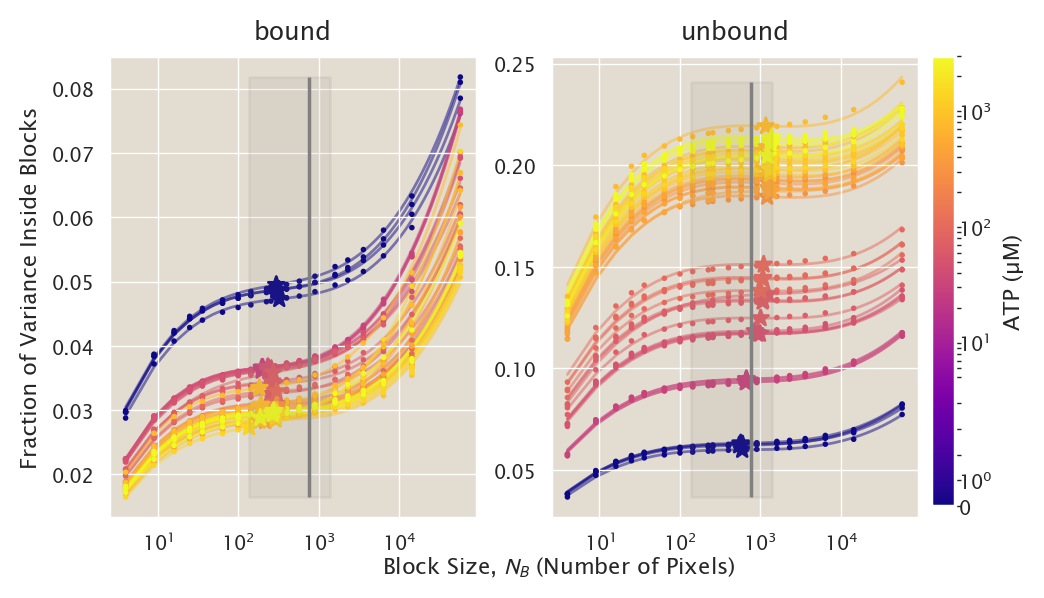

In [24]:
#colorbar settings 
normalize = mcolors.SymLogNorm(linthresh=5, vmin=ATPconc.min(), vmax=ATPconc.max())
colormap = cm.plasma
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(ATPconc)

fig, ax = plt.subplots(1,2, figsize=(6,3))

xvals= np.arange(common_sq[1], common_sq[-1])
for i,fit in enumerate(samp_fits_bound):
    ax[0].plot(xvals**2, fit[0]*np.log(xvals)**3 + fit[1]*np.log(xvals)**2 + fit[2]*np.log(xvals) + fit[3], 
             color=colormap(normalize(ATPconc[i])),
             lw=1,
             alpha=0.5,
             zorder=0)
for i,fit in enumerate(samp_fits_unbound):
    ax[1].plot(xvals**2, fit[0]*np.log(xvals)**3 + fit[1]*np.log(xvals)**2 + fit[2]*np.log(xvals) + fit[3], 
             color=colormap(normalize(ATPconc[i])),
             lw=1,
             alpha=0.5,
             zorder=0)
    
ax[0].scatter(bound_var_allNB_df['N_B'], bound_var_allNB_df['frac_var_in'], color=colormap(normalize(bound_var_allNB_df['ATP'])), s=1)
ax[0].scatter(inflecs_bound**2, inflecs_bound_val, color=colormap(normalize(ATPconc)), marker="*")
ax[0].fill_betweenx((bound_var_allNB_df['frac_var_in'].min(),bound_var_allNB_df['frac_var_in'].max()), inflecs_bound.min()**2, inflecs_unbound.max()**2, alpha=0.1, color='gray')
ax[0].set_xscale('log')
ax[0].vlines(avg_inflec**2, bound_var_allNB_df['frac_var_in'].min(), bound_var_allNB_df['frac_var_in'].max(), color='grey')
#plt.colorbar(scalarmappable)
    
ax[1].scatter(unbound_var_allNB_df['N_B'], unbound_var_allNB_df['Var_In']/unbound_var_allNB_df['Var_Tot'], color=colormap(normalize(unbound_var_allNB_df['ATP'])), s=1)
ax[1].scatter(inflecs_unbound**2, inflecs_unbound_val, color=colormap(normalize(ATPconc)), marker="*")
ax[1].fill_betweenx((unbound_var_allNB_df['frac_var_in'].min(), unbound_var_allNB_df['frac_var_in'].max()), inflecs_bound.min()**2, inflecs_unbound.max()**2, alpha=0.1, color='gray')
ax[1].set_xscale('log')
ax[1].vlines(avg_inflec**2, unbound_var_allNB_df['frac_var_in'].min(), unbound_var_allNB_df['frac_var_in'].max(), color='grey')

#add colorbar
fig.subplots_adjust(right=0.8)
color_bar_ax = fig.add_axes([0.81, 0.13, 0.02, 0.75])
cbar = fig.colorbar(scalarmappable, cax=color_bar_ax)
cbar.ax.tick_params(labelsize=7, width=0.5, length=2)
cbar.set_label(label="ATP (µM)", size=8)#, weight='bold')

#set titles
ax[0].set_title('bound')
ax[1].set_title('unbound')

#set axis labels
fig.supxlabel(f'Block Size, $N_B$ (Number of Pixels)', fontsize=8)
ax[0].set_ylabel('Fraction of Variance Inside Blocks')

#plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/inflec_blosize_all', dpi=400)
# #include legend
# ax[0].legend(fontsize=4, loc='lower right')
# ax[1].legend(fontsize=4, loc='lower right')

for just one image

Text(0, 0.5, 'Fraction of Variance Within Blocks')

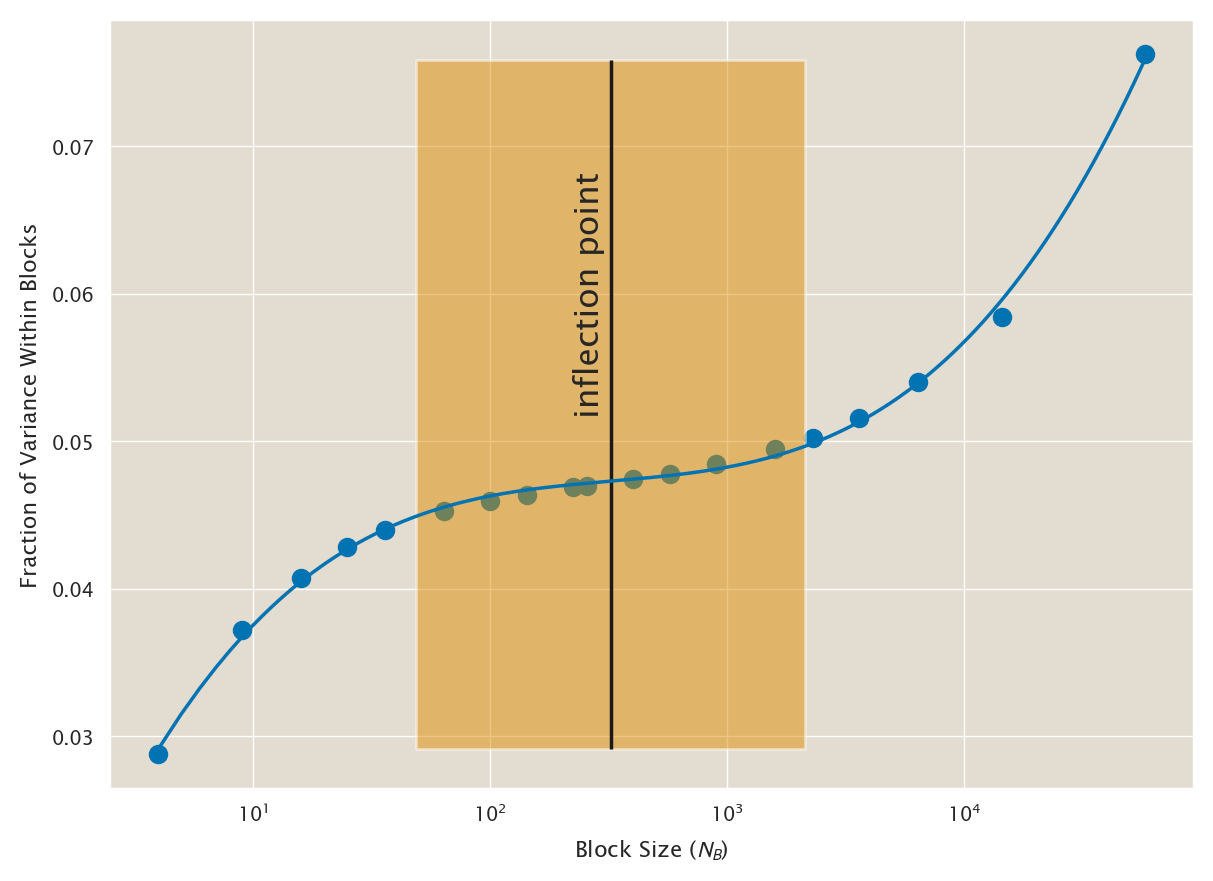

In [25]:
ploti = 3
plot_data = bound_var_allNB_df[bound_var_allNB_df['im']==ploti]['frac_var_in']
plot_inflec = inflecs_bound[ploti]

plt.scatter(np.array(common_sq[1:])**2, plot_data)

samp_fit = np.polyfit(np.log(np.array(common_sq[1:])**2), plot_data, 3)
x_vals = np.arange(common_sq[1:].min()**2, common_sq[1:].max()**2)
y_vals = samp_fit[0]*np.log(x_vals)**3 + samp_fit[1]*np.log(x_vals)**2 + samp_fit[2]*np.log(x_vals) + samp_fit[3]

inflec2 = plot_inflec**2
inflec2yval = samp_fit[0]*np.log(inflec2)**3 + samp_fit[1]*np.log(inflec2)**2 + samp_fit[2]*np.log(inflec2) + samp_fit[3]
inf5up = inflec2yval*1.05
inf5bel = inflec2yval*0.95
inflxup = x_vals[np.where(y_vals>inf5up)[0][0]]
inflxbel= x_vals[np.where(y_vals<inf5bel)[0][-1]]

plt.plot(x_vals, y_vals)
plt.fill_between((inflxbel, inflxup), (y_vals.max(), y_vals.max()), (y_vals.min(), y_vals.min()), alpha=0.5)
plt.vlines(inflec2, y_vals.min(), y_vals.max(), 'k') 
plt.text(inflec2-100, 0.052, 'inflection point', rotation='vertical')
plt.xscale('log')

plt.xlabel(f'Block Size ($N_B$)')
plt.ylabel('Fraction of Variance Within Blocks')
# #plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/BloSizeVar', dpi=400)


## Crop the Image


Crop the image to inscribe the excitation region (~800x800 px)

In [26]:
#Find optimal window size and grid rows
win_size, ngridrows = closest_win_size(400, avg_inflec)
cnrows = ngridrows
cncols = ngridrows

#Creates crop window in pixels
im_shape = bound_array[0].shape
centy, centx = im_shape[0]//2, im_shape[1]//2
ymin= centy - win_size
ymax= centy + win_size
xmin= centx - win_size
xmax= centx + win_size
crop_win=np.s_[:,  ymin:ymax, xmin:xmax]

## Apply 2D Polynomial

In [28]:
bound_poly_crop = np.zeros(bound_array[crop_win].shape)
bound_ev_crop = np.zeros(bound_array[crop_win].shape)
bound_alphas_crop = np.zeros(bound_array[crop_win].shape)

unbound_poly_crop = np.zeros(unbound_array[crop_win].shape)
unbound_ev_crop = np.zeros(unbound_array[crop_win].shape)
unbound_alphas_crop = np.zeros(unbound_array[crop_win].shape)

for i, ATP in enumerate(ATPconc):
    #bound
    im = np.copy(bound_bs[crop_win][i])
    im_biv = evaluateBivPoly(im)
    alpha = np.nanmean(im_biv)/im_biv
    
    bound_poly_crop[i]+=im_biv
    bound_ev_crop[i] += im*alpha
    bound_alphas_crop[i] += alpha
    
    #unbound
    im = np.copy(unbound_bs[crop_win][i])
    im_biv = evaluateBivPoly(im)
    alpha = np.nanmean(im_biv)/im_biv
    
    unbound_poly_crop[i]+=im_biv
    unbound_ev_crop[i] += im*alpha
    unbound_alphas_crop[i] += alpha

Take ratio of evened images

In [29]:
ratio_im = bound_ev_crop/unbound_ev_crop
ratio_im[np.where(ratio_im==np.inf)] = np.nan

Find image means

In [30]:
bound_mean = np.nanmean(bound_ev_crop, axis=(1,2))
unbound_mean = np.nanmean(unbound_ev_crop, axis=(1,2))
ratio_mean = np.nanmean(ratio_im, axis=(1,2))

bound_std = np.nanstd(bound_ev_crop, axis=(1,2))
unbound_std = np.nanstd(unbound_ev_crop, axis=(1,2))
ratio_std = np.nanstd(ratio_im, axis=(1,2))

Fit the averaged even images to a Michaelis-Menten curve

In [80]:
pfit_bound, pcov_bound, yfit_bound, xfit_bound = ATeam_Hill_curve_fit(ATPconc, np.nanmean(bound_ev_crop, axis=(1,2)), ATPconc.max(), [50, 380, 260], returncov=True)
pfit_unbound, yfit_unbound, xfit_unbound = ATeam_Hill_curve_fit(ATPconc, np.nanmean(unbound_ev_crop, axis=(1,2)), ATPconc.max(), [50, 380, 260])
pfit_ratio, yfit_ratio, xfit_ratio = ATeam_Hill_curve_fit(ATPconc, ratio_mean, ATPconc.max(), [50, 380, 260])

If you restrict the fit and want to bound the range

Make grid blocks for analysis of performance

In [35]:
df_vars_crop_bound, _, _ = blovar_for_arr(ATPconc, bound_bs[crop_win], cnrows, cncols)


  0%|          | 0/44 [00:00<?, ?it/s]

In [36]:
#### BOUND ###########

#-- even im --#
#block evlauation where matrices are the shape of the image with the same pixel value in each block
df_vars_ev_crop_bound, blo_means_ev_arr_crop_bound, blo_stds_ev_arr_crop_bound = blovar_for_arr(ATPconc, bound_ev_crop, cnrows, cncols)
#only unique pixel values
cent_means_ev_bound = unique_blovals(blo_means_ev_arr_crop_bound, cnrows, cncols)

#-- alpha --#
#block evlauation where matrices are the shape of the image with the same pixel value in each block
df_vars_alphas_bound, blo_means_alphas_bound, blo_stds_alphas_bound = blovar_for_arr(ATPconc, bound_alphas_crop, cnrows, cncols)
#only unique pixel values
cent_means_alphas_bound = unique_blovals(blo_means_alphas_bound, cnrows, cncols)


######## UNBOUND ############# 

#-- even im --#
#block evlauation where matrices are the shape of the image with the same pixel value in each block
df_vars_ev_crop_unbound, blo_means_ev_arr_crop_unbound, blo_stds_ev_arr_crop_unbound = blovar_for_arr(ATPconc, unbound_ev_crop, cnrows, cncols)
#only unique pixel values
cent_means_ev_unbound = unique_blovals(blo_means_ev_arr_crop_unbound, cnrows, cncols)

#-- alpha --#
#block evlauation where matrices are the shape of the image with the same pixel value in each block
df_vars_alphas_unbound, blo_means_alphas_unbound, blo_stds_alphas_unbound = blovar_for_arr(ATPconc, unbound_alphas_crop, cnrows, cncols)
#only unique pixel values
cent_means_alphas_unbound = unique_blovals(blo_means_alphas_unbound, cnrows, cncols)

######## Ratio ############# 

#-- even im --#
#block evlauation where matrices are the shape of the image with the same pixel value in each block
df_vars_ev_crop_ratio, blo_means_ev_arr_crop_ratio, blo_stds_ev_arr_crop_ratio = blovar_for_arr(ATPconc, ratio_im, cnrows, cncols)
#only unique pixel values
cent_means_ev_ratio = unique_blovals(blo_means_ev_arr_crop_ratio, cnrows, cncols)


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Make an i*j image that indicates block position across the top left to bottom right diagonal

In [37]:
#make an i*j image - increases along the diagonal from top left to bottom right of the image
ij_mat = np.outer(np.arange(win_size*2),np.arange(win_size*2))

Pick a subset of grid block to evaluate the descrepancy in intensity across the image after even-ing

In [38]:
#Number of grid blocks to sample (maybe+1):
num_samp_blocks = 5
samp_block_coord = np.arange(0, ngridrows, ngridrows//num_samp_blocks) 
samp_block_coord += (ngridrows - 1 - samp_block_coord[-1])//2
samp_ij_flat = np.outer(samp_block_coord, samp_block_coord)

Fit each sampled grid block to a Michaelis-Menten function

In [39]:
samp_block_fits_bound = np.zeros((len(samp_block_coord), len(samp_block_coord), 3))
samp_block_fits_unbound = np.zeros((len(samp_block_coord), len(samp_block_coord), 3))
samp_block_fits_ratio = np.zeros((len(samp_block_coord), len(samp_block_coord), 3))

for i, i_px in enumerate(tqdm(samp_block_coord)):
    for j, j_px in enumerate(samp_block_coord):
        samp_pfit_bound,_,_ = ATeam_Hill_curve_fit(ATPconc, cent_means_ev_bound[:, i_px,j_px], ATPconc.max(), [50, 380, 260])
        samp_block_fits_bound[i][j]+=samp_pfit_bound
        
        samp_pfit_unbound,_,_ = ATeam_Hill_curve_fit(ATPconc, cent_means_ev_unbound[:, i_px,j_px], ATPconc.max(), [50, 380, 260])
        samp_block_fits_unbound[i][j]+=samp_pfit_unbound
        
        samp_pfit_ratio,_,_ = ATeam_Hill_curve_fit(ATPconc, cent_means_ev_ratio[:, i_px,j_px], ATPconc.max(), [50, 1, 4])
        samp_block_fits_ratio[i][j]+=samp_pfit_ratio

  0%|          | 0/6 [00:00<?, ?it/s]

# Plots

Before and after evening

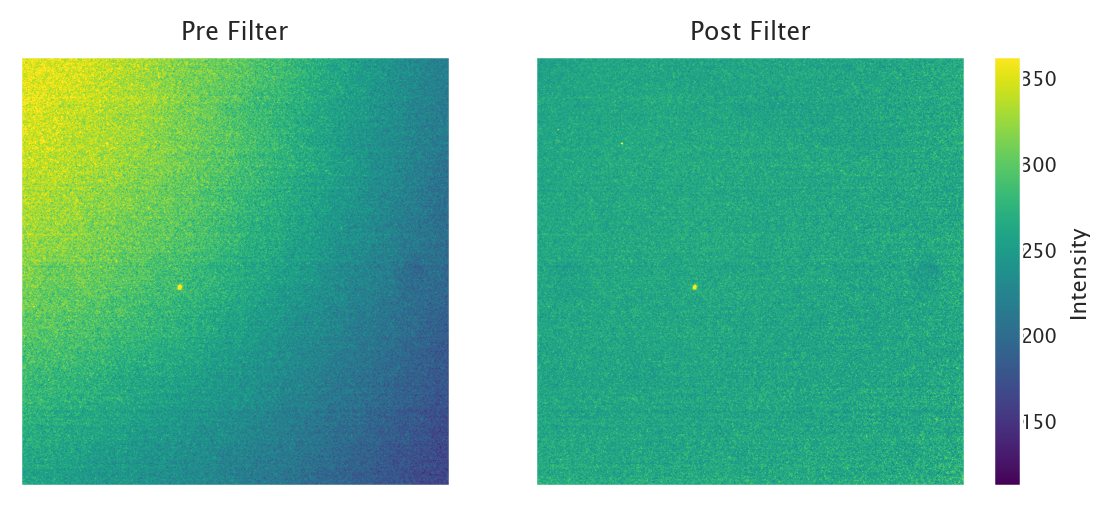

In [40]:
vmin=bound_bs[crop_win][2].min()
vmax=np.percentile(bound_bs[crop_win][2],99)

#colorbar settings
normalize = mcolors.Normalize(vmin=vmin, vmax=vmax)
colormap = cm.viridis
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(np.arange(vmin, vmax))

fig, ax= plt.subplots(1,2)
ax[0].imshow(bound_bs[crop_win][2], vmin=vmin, vmax=vmax)
ax[1].imshow(bound_ev_crop[2], vmin=vmin, vmax=vmax)

ax[0].grid(False)
ax[1].grid(False)

ax[0].xaxis.set_tick_params(labelbottom=False)
ax[0].yaxis.set_tick_params(labelleft=False)
ax[1].xaxis.set_tick_params(labelbottom=False)
ax[1].yaxis.set_tick_params(labelleft=False)

ax[0].set_title('Pre Filter')
ax[1].set_title('Post Filter')
        
#add colorbar
fig.subplots_adjust(right=0.8)
color_bar_ax = fig.add_axes([0.82, 0.28, 0.02, 0.43])
cbar = fig.colorbar(scalarmappable, cax=color_bar_ax)
cbar.ax.tick_params(labelsize=7, length=0.8)
cbar.set_label(label="Intensity", size=8)
#plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/before_after_ev', dpi=400)

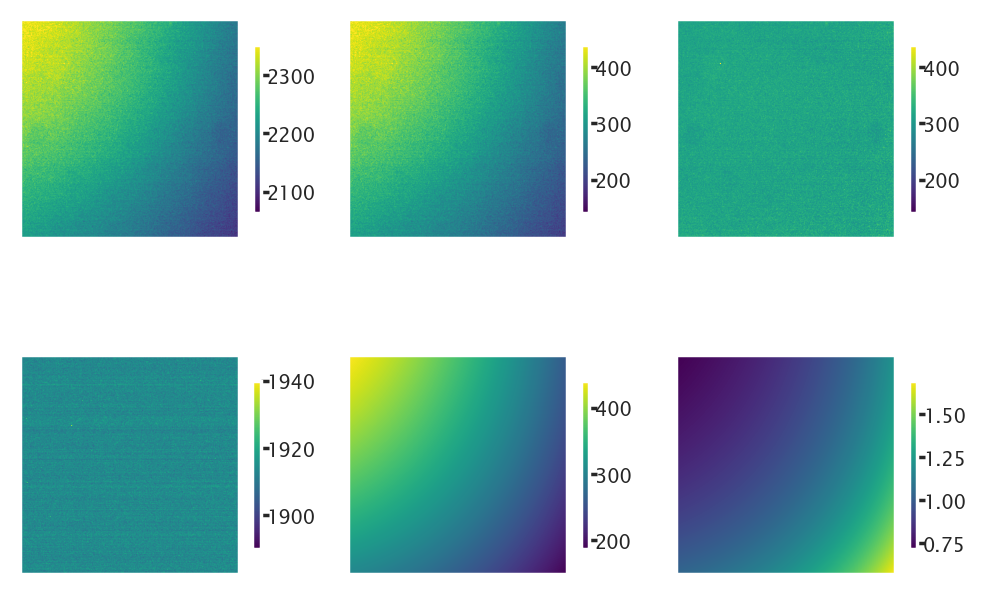

In [41]:
ploti = 10

vmin=bound_bs[crop_win][ploti].min()
vmax=np.percentile(bound_bs[crop_win][ploti],99)

#colorbar settings
normalize = mcolors.Normalize(vmin=vmin, vmax=vmax)
colormap = cm.viridis
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(np.arange(vmin, vmax))

fig, ax= plt.subplots(2,3, figsize=(6,4))
ax00=ax[0][0].imshow(bound_array[crop_win][ploti], vmin=bound_array[crop_win][ploti].min(), vmax=np.percentile(bound_array[crop_win][ploti], 99))
ax01=ax[0][1].imshow(bound_bs[crop_win][ploti], vmin=vmin, vmax=vmax)
ax02=ax[0][2].imshow(bound_ev_crop[ploti], vmin=vmin, vmax=vmax)
ax10=ax[1][0].imshow(dark_avg[ymin:ymax, xmin:xmax], vmin=1890, vmax=1940)
ax11=ax[1][1].imshow(bound_poly_crop[ploti])#, vmin=vmin, vmax=vmax)
ax12=ax[1][2].imshow(bound_alphas_crop[ploti])#, vmin=vmin, vmax=vmax)

for i in range(2):
    for j in range(3):
        ax[i][j].grid(False)
        ax[i][j].xaxis.set_tick_params(labelbottom=False)
        ax[i][j].yaxis.set_tick_params(labelleft=False)

#colorbars
cbar00=fig.colorbar(ax00, ax=ax[0][0], shrink=0.6)
cbar00.ax.tick_params(labelsize=7, length=3)

cbar01=fig.colorbar(ax01, ax=ax[0][1], shrink=0.6)
cbar01.ax.tick_params(labelsize=7, length=3)

cbar02=fig.colorbar(ax02, ax=ax[0][2], shrink=0.6)
cbar02.ax.tick_params(labelsize=7, length=3)

cbar10=fig.colorbar(ax10, ax=ax[1][0], shrink=0.6)
cbar10.ax.tick_params(labelsize=7, length=3)

cbar11=fig.colorbar(ax11, ax=ax[1][1], shrink=0.6)
cbar11.ax.tick_params(labelsize=7, length=3)

cbar12=fig.colorbar(ax12, ax=ax[1][2], shrink=0.6)
cbar12.ax.tick_params(labelsize=7, length=3)
plt.tight_layout
plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/im_ev_procces', dpi=400)

#### Variance Partitioning after evening

In [42]:
ev_vars_tot_bound = np.zeros(len(ATPconc))
ev_vars_in_bound = np.zeros(len(ATPconc))
ev_vars_btwn_bound = np.zeros(len(ATPconc))
ev_vars_tot_unbound = np.zeros(len(ATPconc))
ev_vars_in_unbound = np.zeros(len(ATPconc))
ev_vars_btwn_unbound = np.zeros(len(ATPconc))

for i, atp in enumerate(tqdm(ATPconc)):
    samp_means, samp_stds = quickGridDivide(bound_ev_crop[i], n_rows=cnrows, n_cols=cncols)
    temp_var_tot, temp_var_in, temp_var_btwn = varsources(bound_ev_crop[i], samp_means, samp_stds, n_rows=cnrows, n_cols=cncols)
    ev_vars_tot_bound[i]+=temp_var_tot
    ev_vars_in_bound[i]+=temp_var_in
    ev_vars_btwn_bound[i]+=temp_var_btwn
    
    samp_means, samp_stds = quickGridDivide(unbound_ev_crop[i], n_rows=cnrows, n_cols=cncols)
    temp_var_tot, temp_var_in, temp_var_btwn = varsources(unbound_ev_crop[i], samp_means, samp_stds, n_rows=cnrows, n_cols=cncols)
    ev_vars_tot_unbound[i]+=temp_var_tot
    ev_vars_in_unbound[i]+=temp_var_in
    ev_vars_btwn_unbound[i]+=temp_var_btwn

  0%|          | 0/44 [00:00<?, ?it/s]

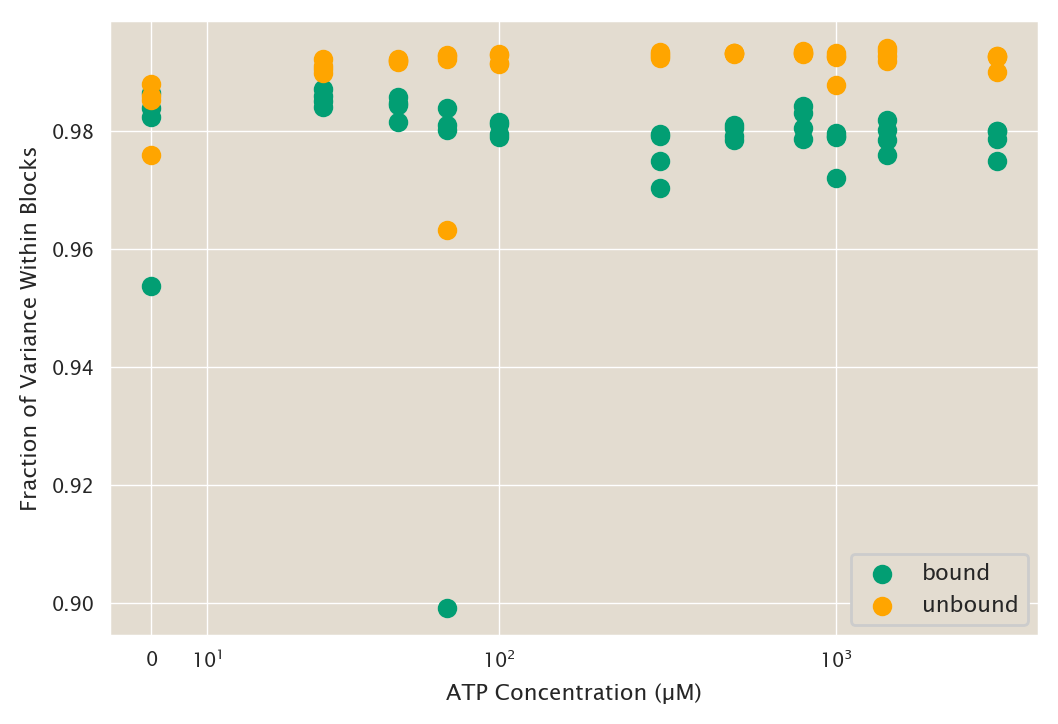

In [43]:
figure = plt.subplots(figsize=(6,4))
plt.scatter(ATPconc, ev_vars_in_bound/ev_vars_tot_bound, c='g', label='bound')
plt.scatter(ATPconc, ev_vars_in_unbound/ev_vars_tot_unbound, c='orange', label='unbound')
plt.xscale('symlog',linthresh=20,linscale=0.3)
plt.ylabel('Fraction of Variance Within Blocks')
plt.xlabel('ATP Concentration (µM)')
plt.legend(loc='lower right')
#plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/evened_var_in_frac', dpi=400)


#### How do alpha filters compare across images? Plot the alpha value for the grid block in each image -  should all be the same

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_21775/2312326863.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.5)


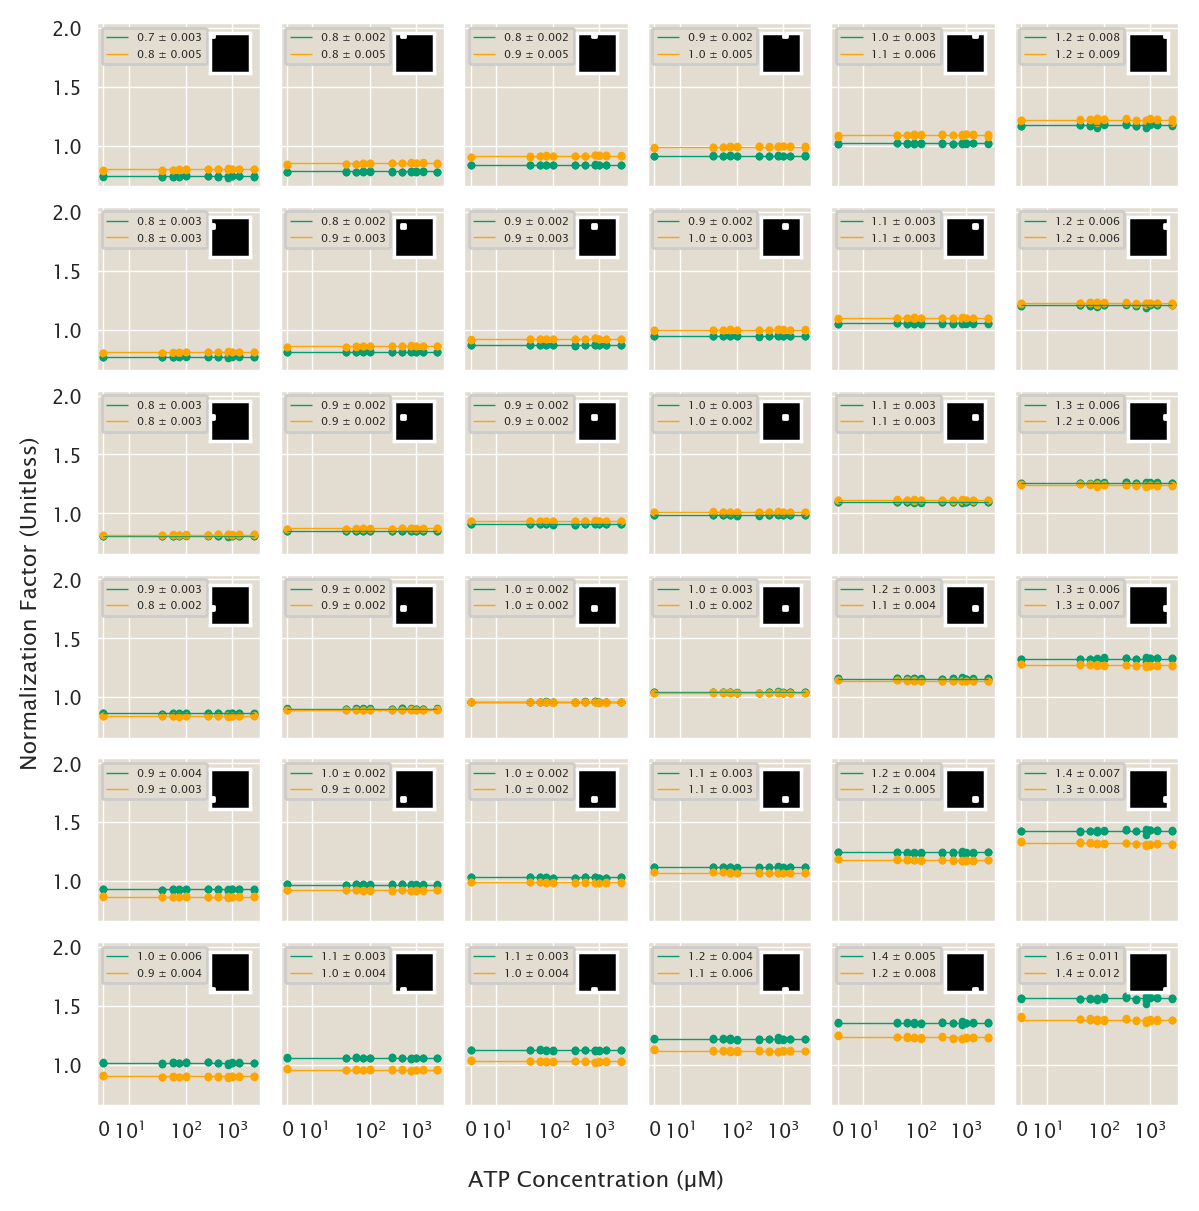

In [187]:
fig, ax = plt.subplots(len(samp_block_coord),len(samp_block_coord),figsize=(6,6))

for i, i_px in enumerate(samp_block_coord):
    for j, j_px in enumerate(samp_block_coord):
        ax[i][j].hlines(np.mean(cent_means_alphas_bound[:, i_px,j_px]), 0, ATPconc.max(), color='g',lw=0.5, label=f'{round(np.mean(cent_means_alphas_bound[:, i_px,j_px]),1)} ± {round(np.std(cent_means_alphas_bound[:, i_px,j_px]),3)}')
        ax[i][j].hlines(np.mean(cent_means_alphas_unbound[:, i_px,j_px]), 0, ATPconc.max(), color='orange', lw=0.5,  label=f'{round(np.mean(cent_means_alphas_unbound[:, i_px,j_px]),1)} ± {round(np.std(cent_means_alphas_unbound[:, i_px,j_px]),3)}')
        
        for atp in np.unique(ATPconc):
            demiis = np.where(ATPconc==atp)
            ax[i][j].scatter(atp*np.ones(len(demiis[0])), cent_means_alphas_bound[demiis][:, i_px,j_px], color='g', s=3)
            ax[i][j].scatter(atp*np.ones(len(demiis[0])), cent_means_alphas_unbound[demiis][:, i_px,j_px], color='orange', s=3)

            
        #fig, ax = plt.subplots(len(samp_block_coord),len(samp_block_coord),figsize=(20,20))
        # create inset plot
        sub_ax = inset_axes(
            parent_axes=ax[i][j],
            width=0.2,
            height=0.2,
            loc='upper right',
            axes_kwargs={
                'facecolor': '#beface'
            }
        )
        
        sub_ax.imshow(np.zeros_like(cent_means_alphas_bound[0]), cmap='Greys_r')
        sub_ax.scatter(j_px, i_px, c='w', marker='s',s=2)
        sub_ax.grid(False)
        sub_ax.xaxis.set_tick_params(labelbottom=False)
        sub_ax.yaxis.set_tick_params(labelleft=False)
        sub_ax.patch.set_linewidth(0.1) 
        

        ax[i][j].set_xscale('symlog',linthresh=20)
        ax[i][j].set_ylim(0.65, 2.05)
        ax[i][j].xaxis.set_tick_params(labelbottom=False, labelsize=7)
        ax[i][j].yaxis.set_tick_params(labelleft=False, labelsize=7)
        ax[-1][j].xaxis.set_tick_params(labelbottom=True)
        ax[i][0].yaxis.set_tick_params(labelleft=True)
        ax[i][j].legend(loc='upper left', fontsize=4)
        #ax[i][j].set_title(f'mean {round(np.mean(cent_means_alphas_unbound[:, i_px,j_px]),1)}, std {round(np.std(cent_means_alphas_unbound[:, i_px,j_px]),3)}', fontsize=10)

fig.supxlabel('ATP Concentration (µM)', fontsize=8)
fig. supylabel('Normalization Factor (Unitless)', fontsize=8)
fig.tight_layout(pad=0.5)
#plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/Alpha_vs_ATPconc_blocks_v3', dpi=400)

#### Look at ATP conc fits

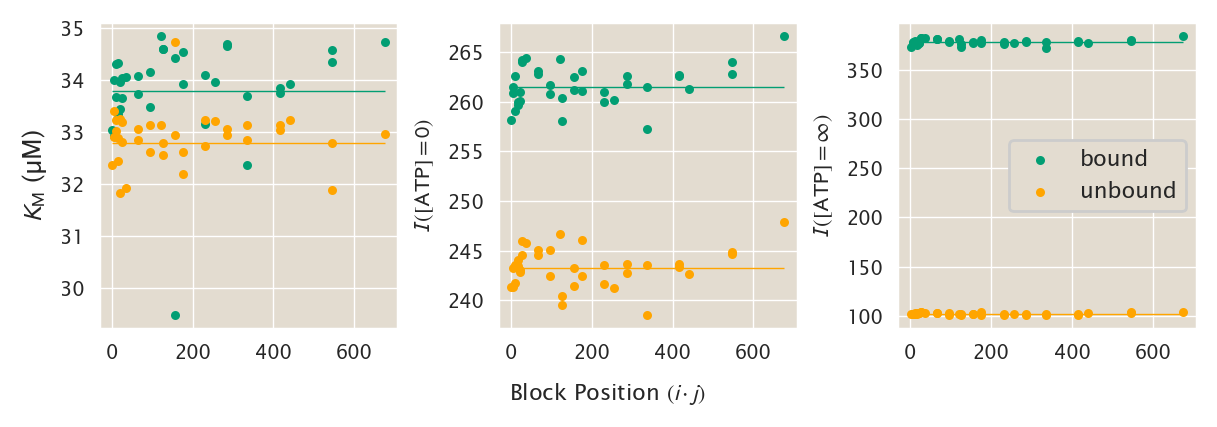

In [186]:
fig, ax = plt.subplots(1,3, figsize=(6,2))

ax[0].scatter(samp_ij_flat, samp_block_fits_bound[:,:,0], c='g', s=5)
ax[0].hlines(pfit_bound[0], samp_ij_flat.min(), samp_ij_flat.max(), color='g',lw=0.5)
ax[0].scatter(samp_ij_flat, samp_block_fits_unbound[:,:,0], c='orange',s=5)
ax[0].hlines(pfit_unbound[0], samp_ij_flat.min(), samp_ij_flat.max(), color='orange', lw=0.5)

ax[2].scatter(samp_ij_flat, samp_block_fits_bound[:,:,1], c='g', s=5, label='bound')
ax[2].hlines(pfit_bound[1], samp_ij_flat.min(), samp_ij_flat.max(), color='g',lw=0.5)
ax[2].scatter(samp_ij_flat, samp_block_fits_unbound[:,:,1], c='orange',s=5, label='unbound')
ax[2].hlines(pfit_unbound[1], samp_ij_flat.min(), samp_ij_flat.max(), color='orange', lw=0.5)

ax[1].scatter(samp_ij_flat, samp_block_fits_bound[:,:,2], c='g', s=5, label='bound')
ax[1].hlines(pfit_bound[2], samp_ij_flat.min(), samp_ij_flat.max(), color='g',lw=0.5)
ax[1].scatter(samp_ij_flat, samp_block_fits_unbound[:,:,2], c='orange',s=5, label='unbound')
ax[1].hlines(pfit_unbound[2], samp_ij_flat.min(), samp_ij_flat.max(), color='orange', lw=0.5)

ax[2].legend()
#fig.subplots_adjust(right=0.8)
#fig.legend(bbox_to_anchor=(1.16, 0.7))

ax[0].set_ylabel(r'$K_\mathrm{M}$ (µM)', fontsize=9)#('Michaelis-Menten Constant', fontsize=9)
ax[1].set_ylabel(r'$I\,(\mathrm{[ATP] = 0})$', fontsize=8)#Maximum Intensity', fontsize=9)
ax[2].set_ylabel(r'$I\,(\mathrm{[ATP] = \infty})$')#('Minimum Intensity', fontsize=9)
fig.supxlabel('Block Position $(i\cdot j)$', fontsize=8)
fig.tight_layout(pad=0.3)

#plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/grid_fit_params_vs_pos', dpi=400)

#### Intensity vs block position

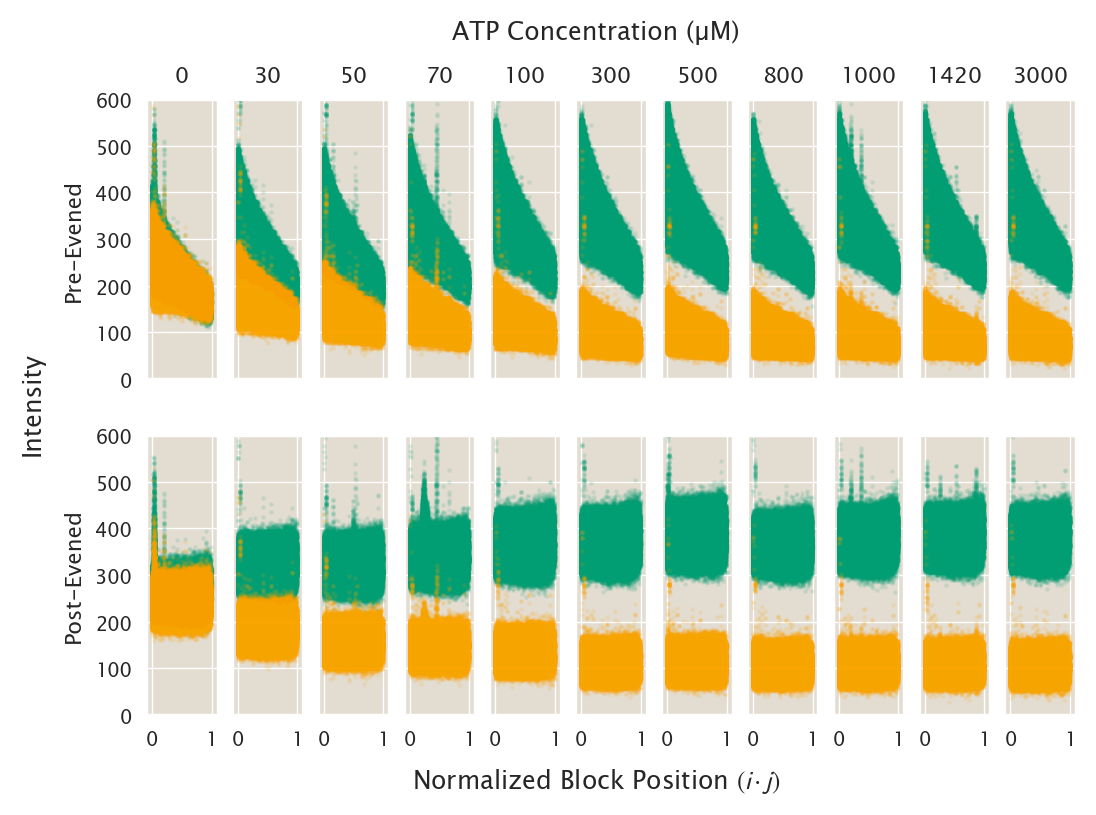

In [61]:
fig, ax = plt.subplots(2,len(np.unique(ATPconc)), figsize=(6,4))

for i, atp in enumerate(np.unique(ATPconc)):
    demiis = np.where(ATPconc==atp)
    ij_mat_temp = np.tile(ij_mat.flatten(), len(demiis[0]))/ij_mat.max()
    
    pxintens = bound_bs[crop_win][demiis].flatten()
    ax[0][i].scatter(ij_mat_temp, pxintens, alpha=0.1, s=0.5, color='g')
    
    pxintens = bound_ev_crop[demiis].flatten()
    ax[1][i].scatter(ij_mat_temp, pxintens, alpha=0.1, s=0.5, color='g')
    
    pxintens = unbound_bs[crop_win][demiis].flatten()
    ax[0][i].scatter(ij_mat_temp, pxintens, alpha=0.1, s=0.5, color='orange')
    
    pxintens = unbound_ev_crop[demiis].flatten()
    ax[1][i].scatter(ij_mat_temp, pxintens, alpha=0.1, s=0.5, color='orange')
    
    ax[0][i].set_ylim(0, 600)
    ax[1][i].set_ylim(0, 600)
    
    ax[0][i].set_xlim(-0.1, 1.1)
    ax[1][i].set_xlim(-0.1, 1.1)
    
    ax[0][i].set_title(atp, fontsize=8)
    
    ax[0][i].yaxis.set_tick_params(labelleft=False)
    ax[1][i].yaxis.set_tick_params(labelleft=False)
    ax[0][i].xaxis.set_tick_params(labelbottom=False)
    
ax[0][0].yaxis.set_tick_params(labelleft=True)
ax[1][0].yaxis.set_tick_params(labelleft=True)
    
ax[0][0].set_ylabel('Pre-Evened')
ax[1][0].set_ylabel('Post-Evened')
fig.supxlabel(r'Normalized Block Position $(i\cdot j)$', fontsize=9)
fig.supylabel('Intensity', fontsize=9)
fig.suptitle('ATP Concentration (µM)', fontsize=9)
#plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/inten_vs_blockpos_forallATP', dpi=400)

#### Corrected intensity histograms and scaling

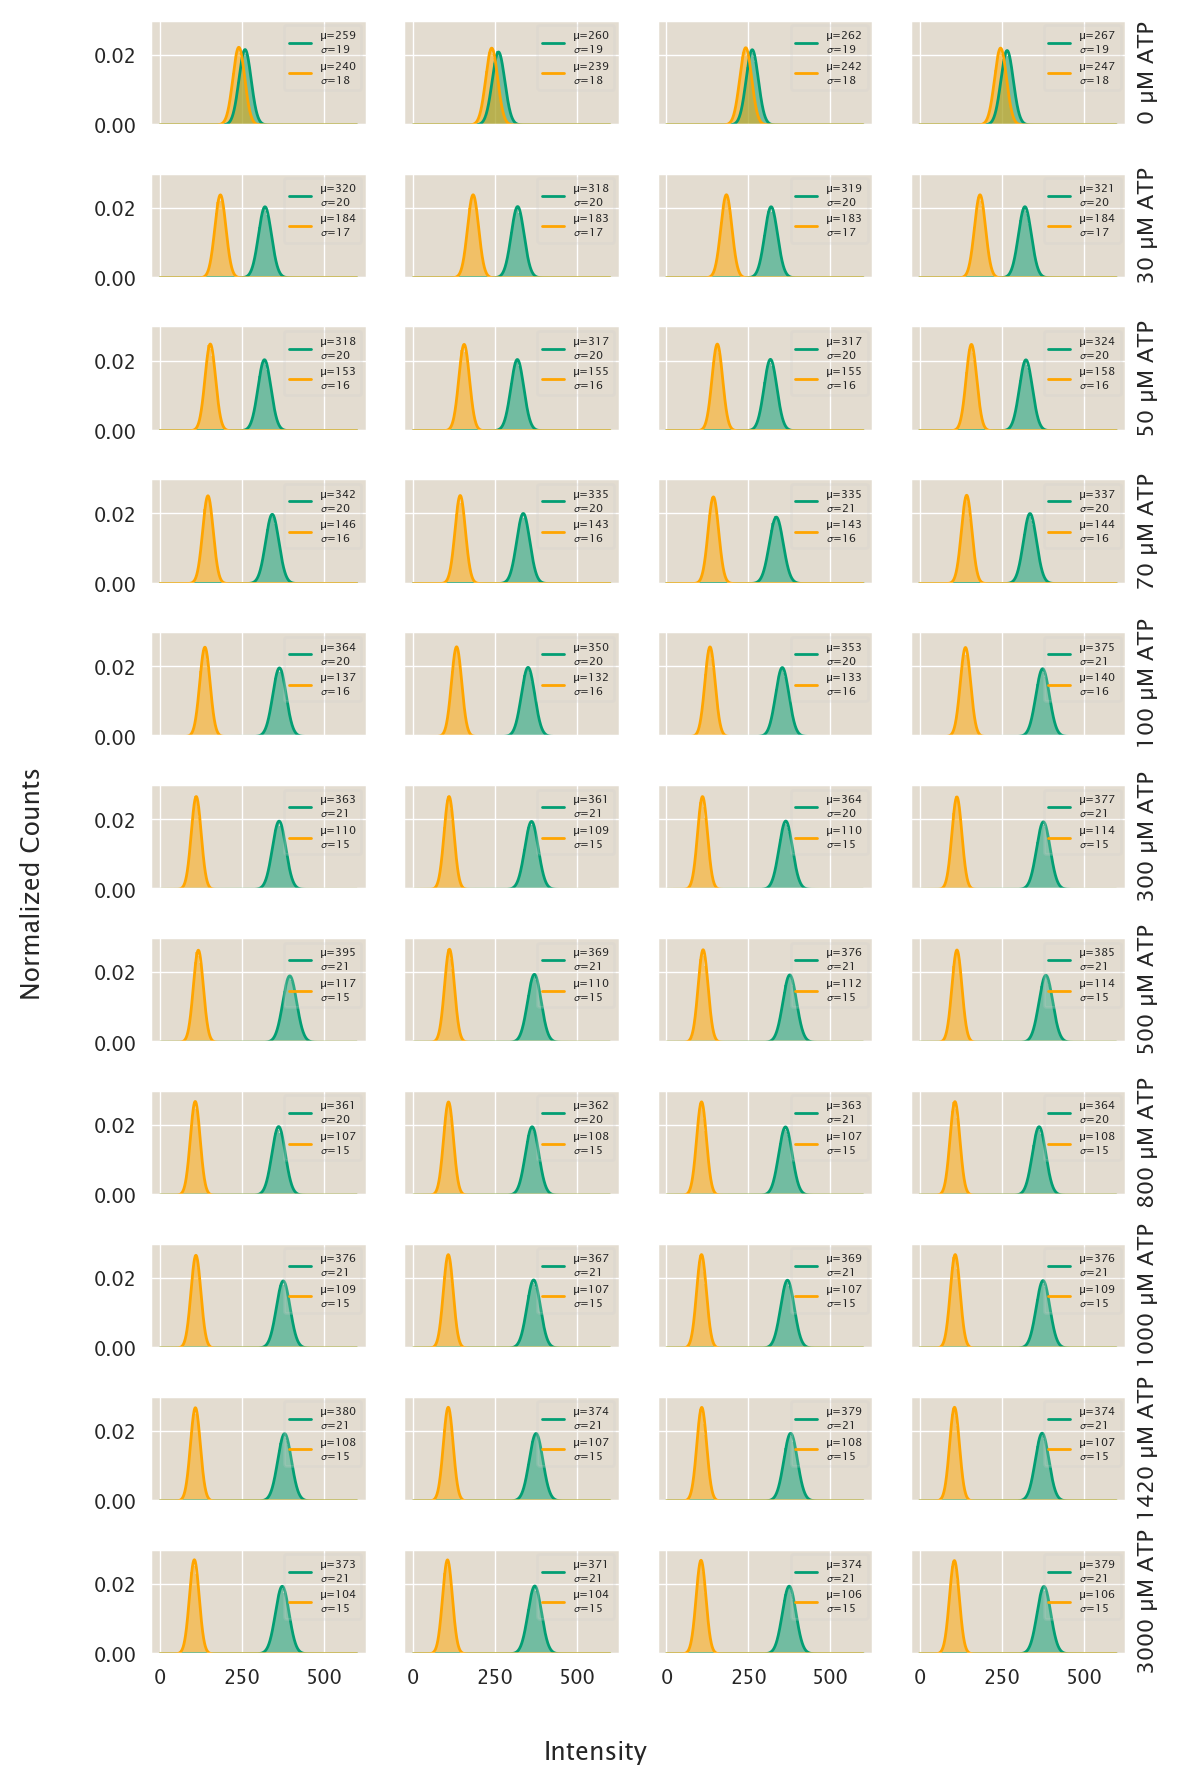

In [243]:
range_low = 0
range_high = 600
gaussDens=lambda x, mu, sigma: (1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-(x-mu)**2/(2*sigma**2))
xRange1=np.linspace(range_low, range_high, 1000)

fig, ax = plt.subplots(len(np.unique(ATPconc)), int(len(ATPconc)/len(np.unique(ATPconc))), figsize=(6,9))

plot_array = np.copy(bound_ev_crop)
for i, ATP in enumerate(np.unique(ATPconc)):
    loc = np.where(ATPconc==ATP)
    for j, val in enumerate(loc[0]):
        ax[i][j].hist(plot_array[val].flatten(), bins=150, range=(range_low, range_high), density=True, color='g', alpha=0.5, edgecolor='none')
        # ax[i][j].set_title(ATP)
        
        mean = np.nanmean(plot_array[val].flatten())
        stdev = np.nanstd(plot_array[val].flatten())
        
        ax[i][j].plot(xRange1, gaussDens(xRange1, mean, stdev), color='g', lw=1, label=f'µ={round(mean)}\n$\sigma$={round(stdev)}')
        ax[i][j].tick_params('x', labelbottom=False)
        ax[i][j].tick_params('y', labelleft=False)
        ax[i][j].set_ylim(0, 0.03)
        #ax[i][j].legend(title=f'ATP = {ATP} µM', title_fontsize=10)
        
plot_array = np.copy(unbound_ev_crop)
for i, ATP in enumerate(np.unique(ATPconc)):
    loc = np.where(ATPconc==ATP)
    for j, val in enumerate(loc[0]):
        ax[i][j].hist(plot_array[val].flatten(), bins=150, range=(range_low, range_high), density=True, color='orange', alpha=0.5, edgecolor='none')
        # ax[i][j].set_title(ATP)
        
        mean = np.nanmean(plot_array[val].flatten())
        stdev = np.nanstd(plot_array[val].flatten())
        
        ax[i][j].plot(xRange1, gaussDens(xRange1, mean, stdev), color='orange', lw=1, label=f'µ={round(mean)}\n$\sigma$={round(stdev)}')
        ax[i][j].tick_params('x', labelbottom=False)
        ax[i][j].tick_params('y', labelleft=False)
        ax[i][j].legend(fontsize=4, loc='upper right', framealpha=0.2)#title=f'ATP = {ATP} µM', title_fontsize=10)
        ax[i][len(loc[0])-1].set_ylabel(f'{ATP} µM ATP')
        ax[i][len(loc[0])-1].yaxis.set_label_position("right")
    ax[i][0].tick_params('y', labelleft=True)

for j in range(int(len(ATPconc)/len(np.unique(ATPconc)))):
    ax[-1][j].tick_params('x', labelbottom=True)
fig.supylabel('Normalized Counts', fontsize=9)
fig.supxlabel('Intensity', fontsize=9)
fig.tight_layout(pad=1.1)
#plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/gauss_hist_fit_ev', dpi=400)  

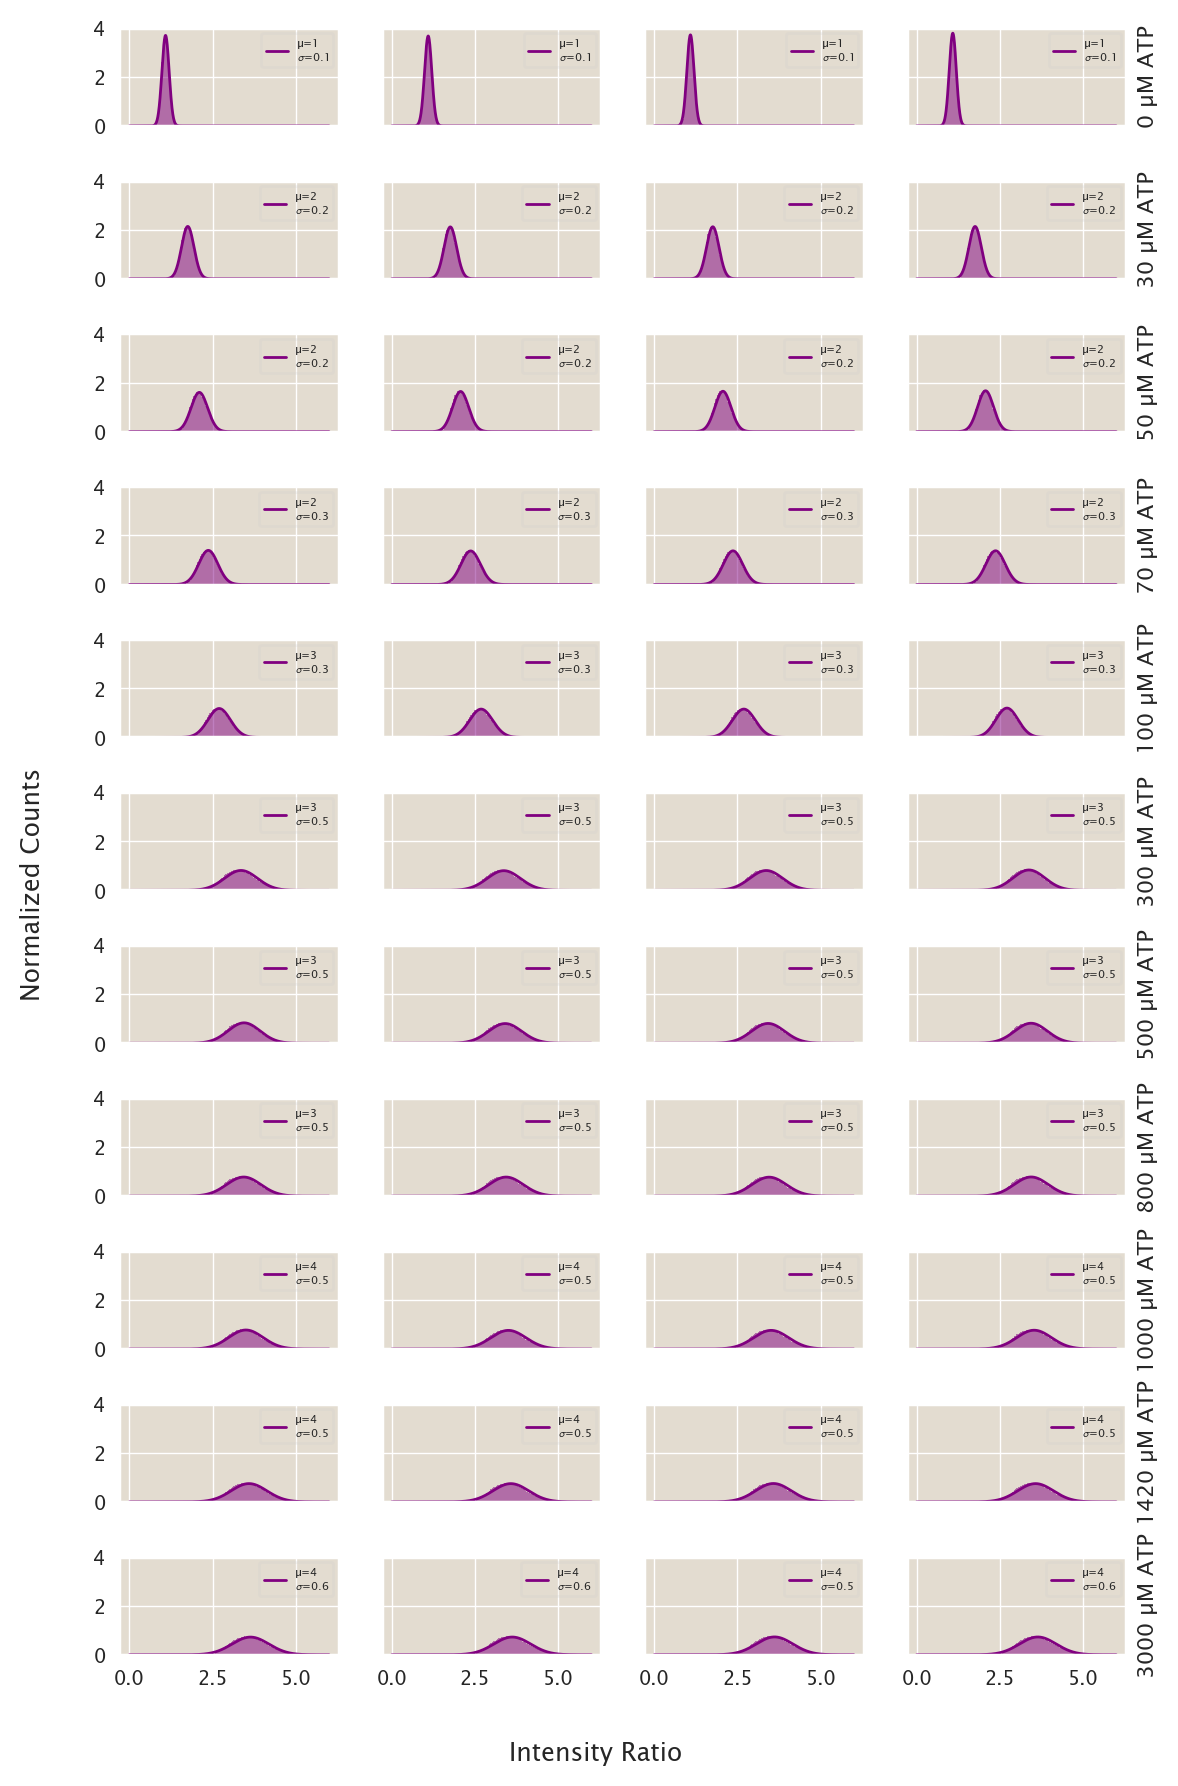

In [244]:
range_low = 0
range_high = 6
gaussDens=lambda x, mu, sigma: (1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-(x-mu)**2/(2*sigma**2))
xRange1=np.linspace(range_low, range_high, 1000)

fig, ax = plt.subplots(len(np.unique(ATPconc)), int(len(ATPconc)/len(np.unique(ATPconc))), figsize=(6,9))

plot_array = np.copy(ratio_im)
for i, ATP in enumerate(np.unique(ATPconc)):
    loc = np.where(ATPconc==ATP)
    for j, val in enumerate(loc[0]):
        ax[i][j].hist(plot_array[val].flatten(), bins=150, range=(range_low, range_high), density=True, color='purple', alpha=0.5, edgecolor='none')
        
        mean = np.nanmean(plot_array[val].flatten())
        stdev = np.nanstd(plot_array[val].flatten())
        
        ax[i][j].plot(xRange1, gaussDens(xRange1, mean, stdev), color='purple', lw=1, label=f'µ={round(mean)}\n$\sigma$={round(stdev,1)}')
        ax[i][j].tick_params('x', labelbottom=False)
        ax[i][j].tick_params('y', labelleft=False)
        ax[i][j].set_ylim(0, 4)
        ax[i][j].legend(fontsize=4, loc='upper right', framealpha=0.2)#title=f'ATP = {ATP} µM', title_fontsize=10)
        ax[i][len(loc[0])-1].set_ylabel(f'{ATP} µM ATP')
        ax[i][len(loc[0])-1].yaxis.set_label_position("right")
    ax[i][0].tick_params('y', labelleft=True)

for j in range(int(len(ATPconc)/len(np.unique(ATPconc)))):
    ax[-1][j].tick_params('x', labelbottom=True)
fig.supylabel('Normalized Counts', fontsize=9)
fig.supxlabel('Intensity Ratio', fontsize=9)
fig.tight_layout(pad=1.1)
#plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/gauss_hist_fit_ratios', dpi=400)  

#### mean vs stdev scaling

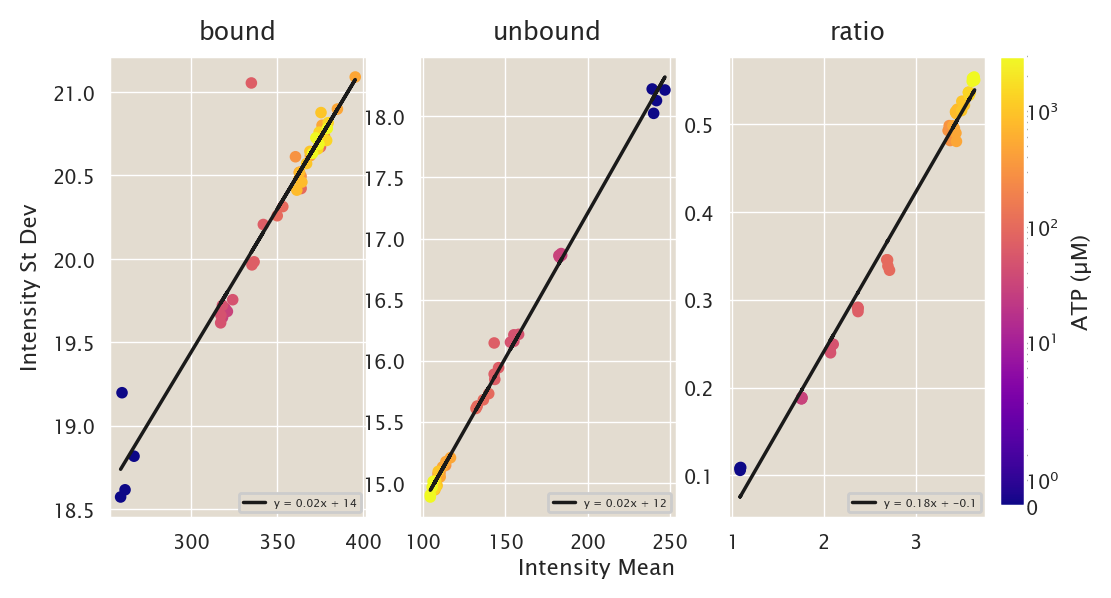

In [245]:
#colorbar settings
normalize = mcolors.SymLogNorm(linthresh=5, vmin=ATPconc.min(), vmax=ATPconc.max())
colormap = cm.plasma
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(ATPconc)

#create figure
fig, ax = plt.subplots(1,3, figsize=(6.5,3))
ax[0].scatter(bound_mean, bound_std, color=colormap(normalize(ATPconc)), s=10)
ax[1].scatter(unbound_mean, unbound_std, color=colormap(normalize(ATPconc)), s=10)
ax[2].scatter(ratio_mean, ratio_std, color=colormap(normalize(ATPconc)), s=10)

#fit bound
coefficients, cov= np.polyfit(bound_mean, bound_std, deg=1, cov='unscaled')
conf_int = np.sqrt(np.diag(cov))
# Create a polynomial function using the coefficients
poly_function = np.poly1d(coefficients)
# Generate y values for the fitted line
y_fit = poly_function(bound_mean)
#plot
ax[0].plot(bound_mean, y_fit, color='k', label=f'y = {round(coefficients[0],2)}x + {round(coefficients[1])}')# slope = {round(coefficients[0],2)}±{round(conf_int[0],5)}, intercept = {round(coefficients[1],2)}±{round(conf_int[1],2)}')

#fit unbound
coefficients, cov = np.polyfit(unbound_mean, unbound_std, deg=1, cov='unscaled')
conf_int = np.sqrt(np.diag(cov))
# Create a polynomial function using the coefficients
poly_function = np.poly1d(coefficients)
# Generate y values for the fitted line
y_fit = poly_function(unbound_mean)
#plot
ax[1].plot(unbound_mean, y_fit, color='k', label=f'y = {round(coefficients[0],2)}x + {round(coefficients[1])}')

#fit ratio
coefficients, cov = np.polyfit(ratio_mean, ratio_std, deg=1, cov='unscaled')
conf_int = np.sqrt(np.diag(cov))
# Create a polynomial function using the coefficients
poly_function = np.poly1d(coefficients)
# Generate y values for the fitted line
y_fit = poly_function(ratio_mean)
#plot
ax[2].plot(ratio_mean, y_fit, color='k', label=f'y = {round(coefficients[0],2)}x + {round(coefficients[1],1)}')

#add colorbar
fig.subplots_adjust(right=0.8)
color_bar_ax = fig.add_axes([0.81, 0.13, 0.02, 0.75])
cbar = fig.colorbar(scalarmappable, cax=color_bar_ax)
cbar.ax.tick_params(labelsize=7, width=0.5, length=0.8)
cbar.set_label(label="ATP (µM)", size=8)#, weight='bold')

#set titles
ax[0].set_title('bound')
ax[1].set_title('unbound')
ax[2].set_title('ratio')

#set axis labels
fig.supxlabel('Intensity Mean', fontsize=8)
ax[0].set_ylabel('Intensity St Dev')

#include legend
ax[0].legend(fontsize=4, loc='lower right')
ax[1].legend(fontsize=4, loc='lower right')
ax[2].legend(fontsize=4, loc='lower right')
#fig.tight_layout()
#plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/std_vs_mean', dpi=400)

#### Calibration Curve

In [241]:
#compute least squares error:

#y vals on curve for all ATPconc
func_yvals =  ATeam_Hill(ATPconc, pfit_ratio[0], pfit_ratio[1], pfit_ratio[2])
    
#compute the residuals
ratio_res = ratio_mean-func_yvals


ratio_by_ATP = ratio_mean.reshape(len(ATPconc)//4, 4)



In [242]:
func_yvals

array([1.03711972, 1.03711972, 1.03711972, 1.03711972, 1.84071795,
       1.84071795, 1.84071795, 1.84071795, 2.1537454 , 2.1537454 ,
       2.1537454 , 2.1537454 , 2.37751407, 2.37751407, 2.37751407,
       2.37751407, 2.61460711, 2.61460711, 2.61460711, 2.61460711,
       3.21341892, 3.21341892, 3.21341892, 3.21341892, 3.3922172 ,
       3.3922172 , 3.3922172 , 3.3922172 , 3.50632752, 3.50632752,
       3.50632752, 3.50632752, 3.54686193, 3.54686193, 3.54686193,
       3.54686193, 3.59657081, 3.59657081, 3.59657081, 3.59657081,
       3.66175779, 3.66175779, 3.66175779, 3.66175779])

In [237]:
ATeam_Hill(np.unique(ATPconc), pfit_ratio[0], pfit_ratio[1], pfit_ratio[2])

array([1.03711972, 1.84071795, 2.1537454 , 2.37751407, 2.61460711,
       3.21341892, 3.3922172 , 3.50632752, 3.54686193, 3.59657081,
       3.66175779])

[70.27859498  3.72324308  1.03711972]


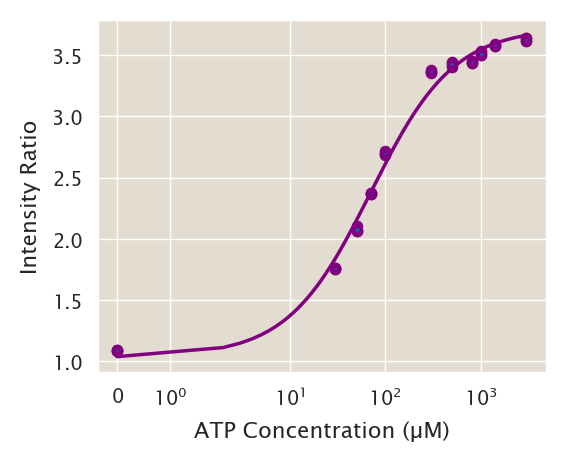

In [204]:
fig, ax= plt.subplots(figsize=(3, 2.5))
plt.scatter(ATPconc, ratio_mean, c='purple', s=10)
plt.plot(xfit_ratio, yfit_ratio, c='purple')
yavg = np.mean(ratio_mean.reshape(len(ratio_mean)//4, 4), axis=1)
yerr = scipy.stats.sem(ratio_mean.reshape(len(ratio_mean)//4, 4), axis=1)
plt.errorbar(np.unique(ATPconc), yavg, yerr,ls='none')
plt.xscale('Symlog')
plt.ylabel('Intensity Ratio')
plt.xlabel('ATP Concentration (µM)')
plt.tight_layout()
print(pfit_ratio)
#plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/Cal_Curve', dpi=400)

Text(0, 0.5, 'ATP Concentration (µM)')

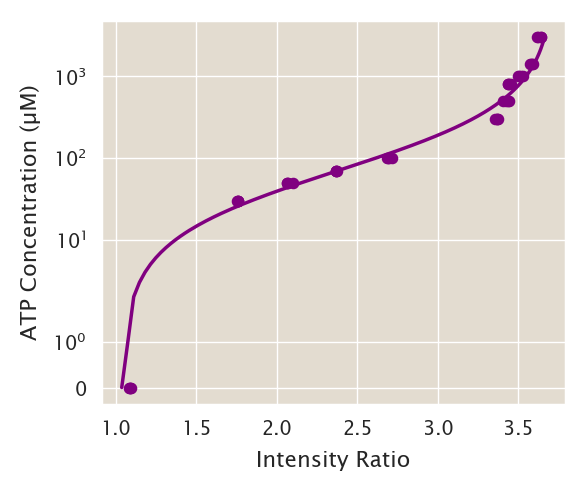

In [58]:
fig, ax= plt.subplots(figsize=(3, 2.5))
plt.scatter(ratio_mean, ATPconc, c='purple', s=10)
plt.plot(yfit_ratio, xfit_ratio, c='purple')
plt.yscale('Symlog')
plt.xlabel('Intensity Ratio')
plt.ylabel('ATP Concentration (µM)')
#plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/Cal_Curve', dpi=400)

#### Calibration fit vs block position

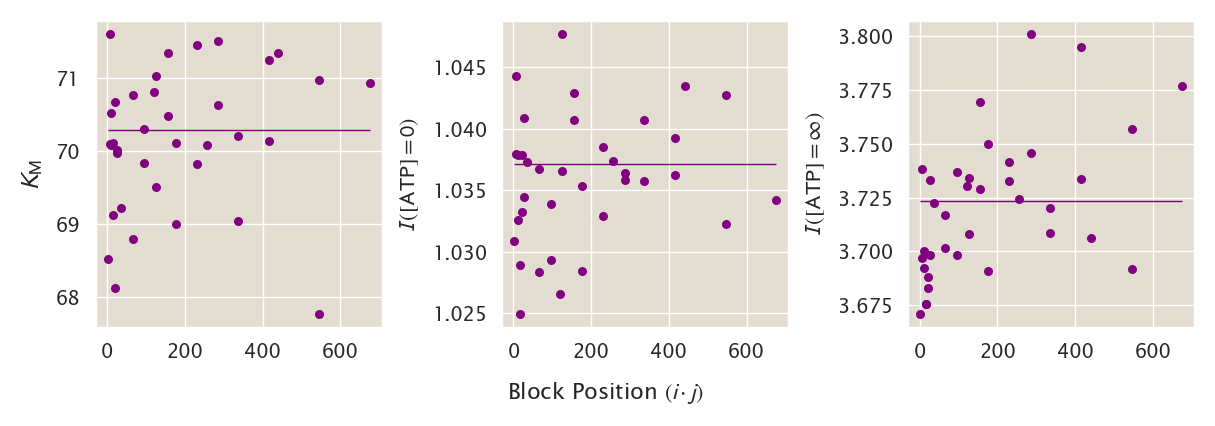

In [59]:
fig, ax = plt.subplots(1,3, figsize=(6,2))

ax[0].scatter(samp_ij_flat, samp_block_fits_ratio[:,:,0], c='purple', s=5)
ax[0].hlines(pfit_ratio[0], samp_ij_flat.min(), samp_ij_flat.max(), color='purple',lw=0.5)

ax[2].scatter(samp_ij_flat, samp_block_fits_ratio[:,:,1], c='purple', s=5)
ax[2].hlines(pfit_ratio[1], samp_ij_flat.min(), samp_ij_flat.max(), color='purple',lw=0.5)

ax[1].scatter(samp_ij_flat, samp_block_fits_ratio[:,:,2], c='purple', s=5,)
ax[1].hlines(pfit_ratio[2], samp_ij_flat.min(), samp_ij_flat.max(), color='purple',lw=0.5)

ax[0].set_ylabel(r'$K_\mathrm{M}$', fontsize=9)#('Michaelis-Menten Constant', fontsize=9)
ax[1].set_ylabel(r'$I\,(\mathrm{[ATP] = 0})$', fontsize=8)#Maximum Intensity', fontsize=9)
ax[2].set_ylabel(r'$I\,(\mathrm{[ATP] = \infty})$')#('Minimum Intensity', fontsize=9)
fig.supxlabel('Block Position $(i\cdot j)$', fontsize=8)
fig.tight_layout(pad=0.3)
#plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/grid_fit_params_vs_pos_ratio', dpi=400)

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_21775/1730304966.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.5)


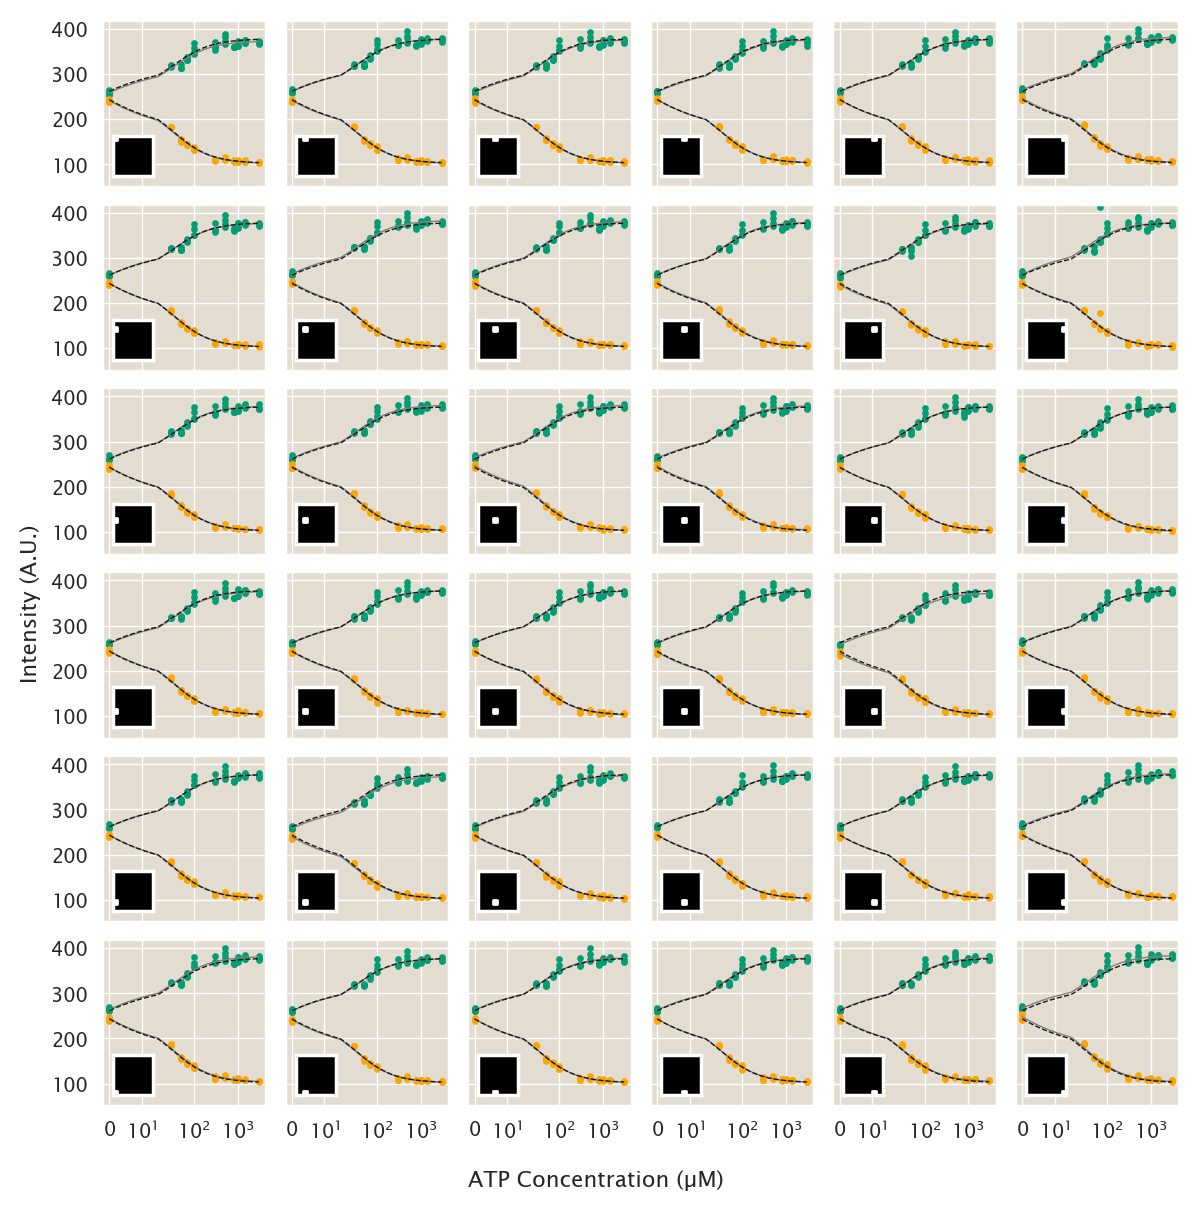

In [60]:
fig, ax = plt.subplots(len(samp_block_coord),len(samp_block_coord), figsize=(6,6))

for i, i_px in enumerate(samp_block_coord):
    for j, j_px in enumerate(samp_block_coord):
        for atp in np.unique(ATPconc):
            demiis = np.where(ATPconc==atp)
            ax[i][j].scatter(atp*np.ones(len(demiis[0])), cent_means_ev_bound[demiis][:, i_px,j_px], color='g', s=2)
            ax[i][j].scatter(atp*np.ones(len(demiis[0])), cent_means_ev_unbound[demiis][:, i_px,j_px], color='orange', s=2)
        
        ax[i][j].plot(np.arange(ATPconc.max()), ATeam_Hill(np.arange(ATPconc.max()), samp_block_fits_bound[i,j,0], samp_block_fits_bound[i,j,1], samp_block_fits_bound[i,j,2]), c='grey', lw=0.5)
        ax[i][j].plot(xfit_bound,yfit_bound, c='k', ls='--', lw=0.5)
        
        ax[i][j].plot(np.arange(ATPconc.max()), ATeam_Hill(np.arange(ATPconc.max()), samp_block_fits_unbound[i,j,0], samp_block_fits_unbound[i,j,1], samp_block_fits_unbound[i,j,2]), c='grey', lw=0.5)
        ax[i][j].plot(xfit_unbound,yfit_unbound, c='k', ls='--', lw=0.5)
        
        #fig, ax = plt.subplots(len(samp_block_coord),len(samp_block_coord),figsize=(20,20))
        # create inset plot
        sub_ax = inset_axes(
            parent_axes=ax[i][j],
            width=0.2,
            height=0.2,
            loc='lower left',
            axes_kwargs={
                'facecolor': '#beface'
            }
        )
        
        sub_ax.imshow(np.zeros_like(cent_means_alphas_bound[0]), cmap='Greys_r')
        sub_ax.scatter(j_px, i_px, c='w', marker='s',s=2)
        sub_ax.grid(False)
        sub_ax.xaxis.set_tick_params(labelbottom=False)
        sub_ax.yaxis.set_tick_params(labelleft=False)
        sub_ax.patch.set_linewidth(0.1) 
        
        ax[i][j].set_xscale('symlog',linthresh=15)
        ax[i][j].set_ylim(50, 420)
        ax[i][j].xaxis.set_tick_params(labelbottom=False)
        ax[i][j].yaxis.set_tick_params(labelleft=False)
        ax[-1][j].xaxis.set_tick_params(labelbottom=True)
        ax[i][0].yaxis.set_tick_params(labelleft=True)
        #ax[i][j].set_title(f'mean {round(np.mean(cent_means_ev[:, i_px,j_px]),1)}, std {round(np.std(cent_means_ev[:, i_px,j_px]),3)}', fontsize=10)
fig.supxlabel('ATP Concentration (µM)', fontsize=8)
fig. supylabel('Intensity (A.U.)', fontsize=8)
fig.tight_layout(pad=0.5)
#plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/inten_fit_perBlock', dpi=400)        
#plt.colorbar(scalarmappable)

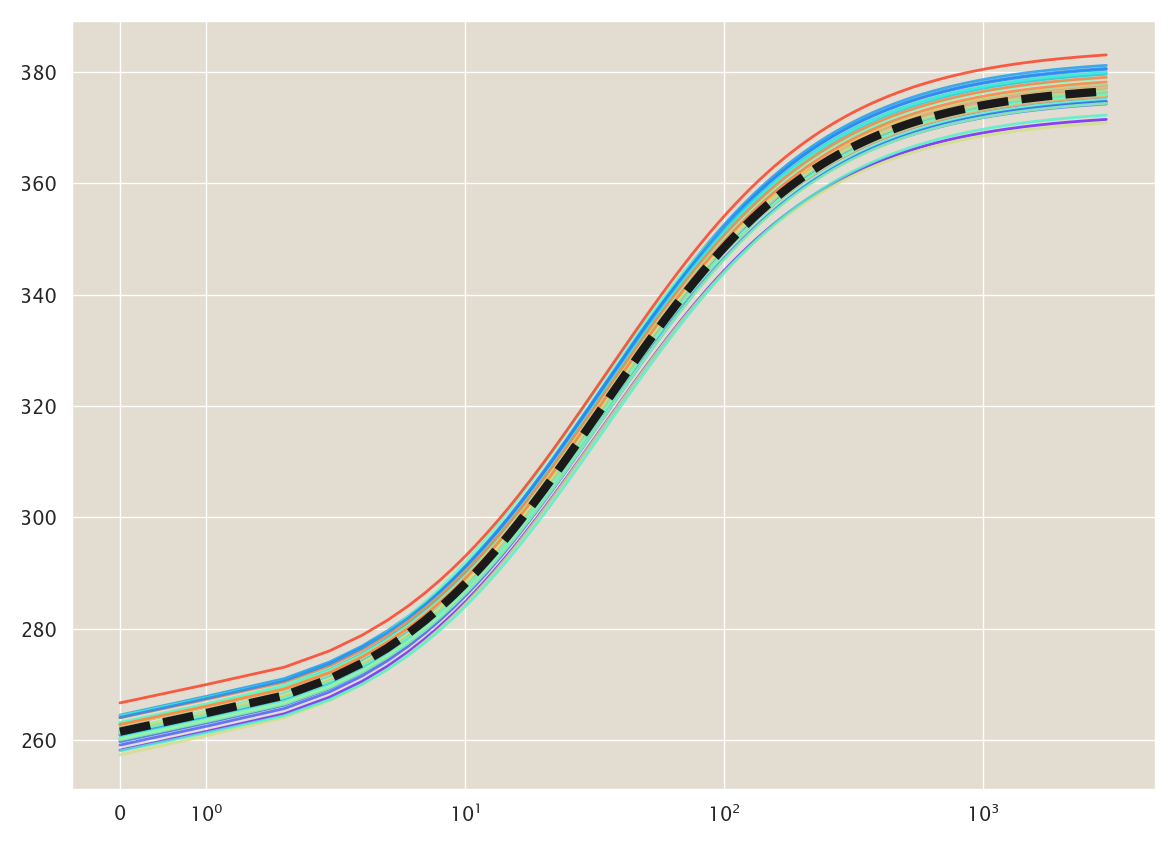

In [101]:
#colorbar settings
#normalize = mcolors.SymLogNorm(linthresh=5, vmin=ATPconc.min(), vmax=ATPconc.max())
normalize = mcolors.PowerNorm(0.5,vmin=0, vmax=ngridrows**2)
colormap = cm.rainbow
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(np.arange(ngridrows**2))

for i, i_px in enumerate(samp_block_coord):
    for j, j_px in enumerate(samp_block_coord):
        # for atp in np.unique(ATPconc):
        #     demiis = np.where(ATPconc==atp)
        #     ax[i][j].scatter(atp*np.ones(len(demiis[0])), cent_means_ev_bound[demiis][:, i_px,j_px], color='g', s=2)
        #     ax[i][j].scatter(atp*np.ones(len(demiis[0])), cent_means_ev_unbound[demiis][:, i_px,j_px], color='orange', s=2)
        
        plt.plot(np.arange(ATPconc.max()), ATeam_Hill(np.arange(ATPconc.max()), samp_block_fits_bound[i,j,0], samp_block_fits_bound[i,j,1], samp_block_fits_bound[i,j,2]), c=colormap(normalize(i_px*j_px)), lw=1, alpha=0.8)
plt.plot(xfit_bound,yfit_bound, c='k', ls='--', lw=3)
plt.xscale('symlog',linthresh=1, linscale=0.3)
        # ax[i][j].plot(np.arange(ATPconc.max()), ATeam_Hill(np.arange(ATPconc.max()), samp_block_fits_unbound[i,j,0], samp_block_fits_unbound[i,j,1], samp_block_fits_unbound[i,j,2]), c='grey', lw=0.5)
        # ax[i][j].plot(xfit_unbound,yfit_unbound, c='k', ls='--', lw=0.5)

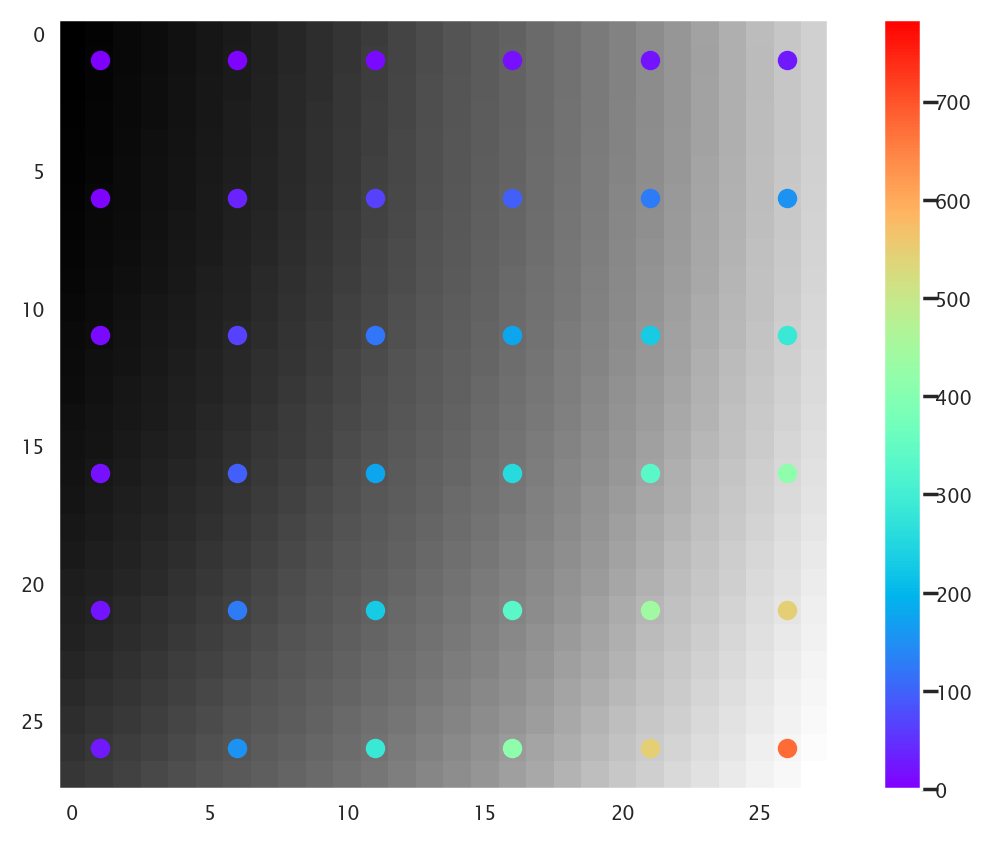

In [ ]:
#colorbar settings
#normalize = mcolors.SymLogNorm(linthresh=5, vmin=ATPconc.min(), vmax=ATPconc.max())
normalize = mcolors.Normalize(vmin=0, vmax=ngridrows**2)
colormap = cm.rainbow
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(np.arange(ngridrows**2))

plt.imshow(np.mean(cent_means_alphas_unbound, axis=0), cmap=cm.Greys_r)
for i in samp_block_coord:
    for j in samp_block_coord:
        plt.scatter(i,j, color = colormap(normalize(i*j)))
plt.colorbar(scalarmappable)
plt.grid(False)

Text(0.5, 0, 'ATP Concentration (µM)')

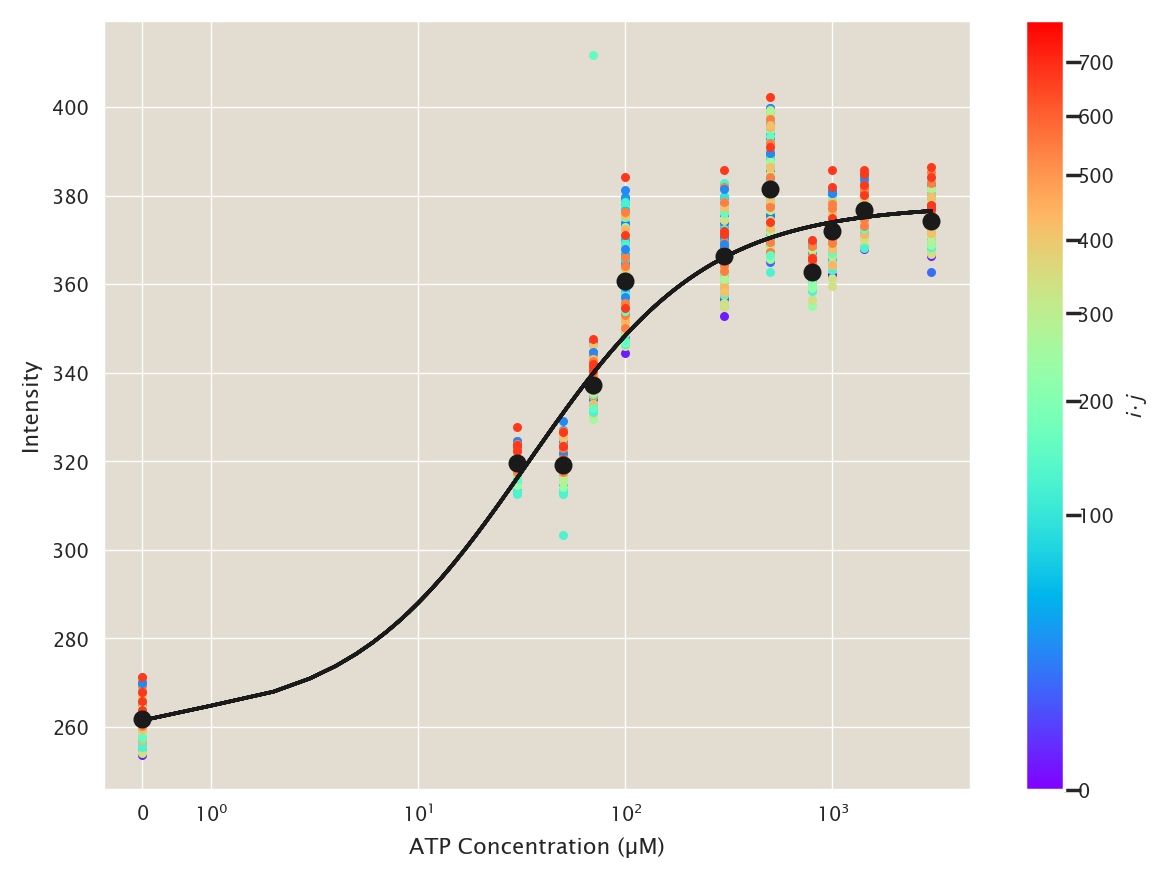

In [96]:
fig, ax = plt.subplots(1,1)
 
# Setting the background color of the plot 
# using set_facecolor() method
#ax.set_facecolor("#e6e6e6")
#colorbar settings
#normalize = mcolors.SymLogNorm(linthresh=5, vmin=ATPconc.min(), vmax=ATPconc.max())
normalize = mcolors.PowerNorm(0.5, vmin=0, vmax=ngridrows**2)
colormap = cm.rainbow
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(np.arange(ngridrows**2))

for atp in np.unique(ATPconc):
    demiis = np.where(ATPconc==atp)
    for i, i_px in enumerate(samp_block_coord):
        for j, j_px in enumerate(samp_block_coord):
            plt.scatter(atp*np.ones(len(demiis[0])), cent_means_ev_bound[demiis][:, i_px,j_px], color=colormap(normalize(i_px*j_px)),s=5)
            #plt.plot(np.arange(ATPconc.max()), ATeam_Hill(np.arange(ATPconc.max()), samp_block_fits_bound[i,j,0], samp_block_fits_bound[i,j,1], samp_block_fits_bound[i,j,2]), color=colormap(normalize(i_px*j_px)))

    plt.scatter(atp, np.nanmean(cent_means_ev_bound[demiis]), c='k', s=30)
    plt.plot(xfit_bound,yfit_bound, c='k')
            # plt.scatter(atp*np.ones(len(demiis[0])), cent_means_alphas[demiis][:, 30,30], c='g')

# for i, i_px in enumerate(samp_block_coord):
#     for j, j_px in enumerate(samp_block_coord):
#         #ax[i][j].hlines(np.mean(cent_means_ev[:, i_px,j_px]), 0, ATPconc.max(), color=colormap(normalize(i_px*j_px)), lw=1)
#         for atp in np.unique(ATPconc):
#             demiis = np.where(ATPconc==atp)
#             ax[i][j].scatter(atp*np.ones(len(demiis[0])), cent_means_ev_bound[demiis][:, i_px,j_px], color=colormap(normalize(i_px*j_px)))
#         ax[i][j].plot(xfit_bound,yfit_bound, c='k')
#         ax[i][j].plot(np.arange(ATPconc.max()), ATeam_Hill(np.arange(ATPconc.max()), samp_block_fits_bound[i,j,0], samp_block_fits_bound[i,j,1], samp_block_fits_bound[i,j,2]), c='grey')

plt.xscale('symlog',linthresh=1, linscale=0.3)
plt.colorbar(scalarmappable, label=f'$i \cdot j$')
plt.ylabel('Intensity')
plt.xlabel('ATP Concentration (µM)')


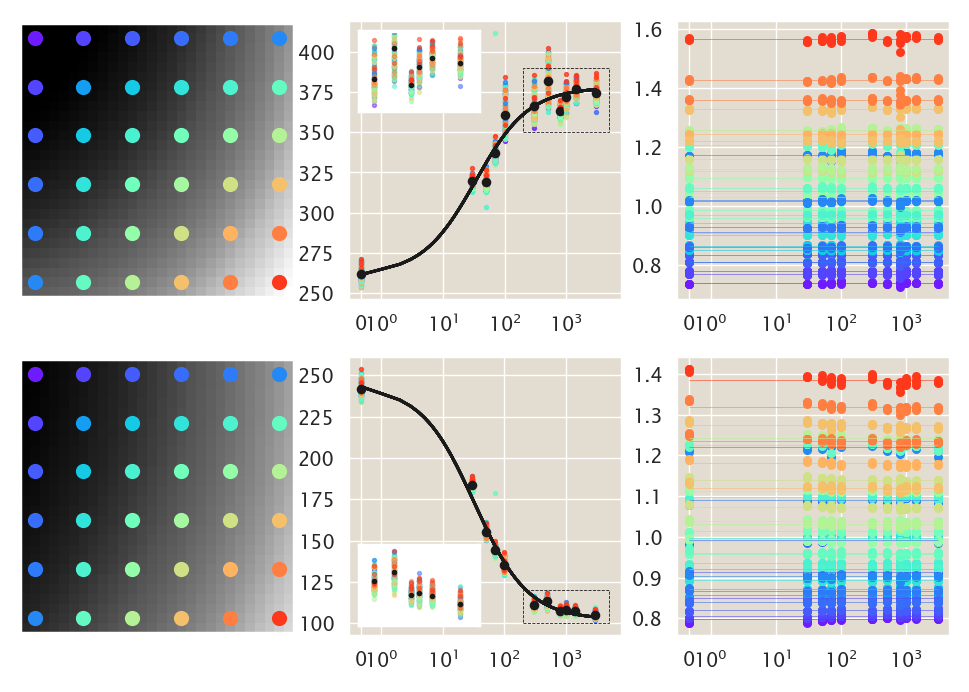

In [130]:
fig, ax = plt.subplots(2,3, figsize=(6, 4))

#colorbar settings
#normalize = mcolors.SymLogNorm(linthresh=5, vmin=ATPconc.min(), vmax=ATPconc.max())
normalize = mcolors.PowerNorm(0.5, vmin=0, vmax=ngridrows**2)
colormap = cm.rainbow
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(np.arange(ngridrows**2))

imvmin = np.mean(cent_means_alphas_unbound, axis=0).min()
imvmax = np.mean(cent_means_alphas_bound, axis=0).max()

#_____________________________________
ax[0][0].imshow(np.mean(cent_means_alphas_bound, axis=0), cmap=cm.Greys_r, vmin=imvmin, vmax=imvmax)
ax[1][0].imshow(np.mean(cent_means_alphas_unbound, axis=0), cmap=cm.Greys_r, vmin=imvmin, vmax=imvmax)
for i in samp_block_coord:
    for j in samp_block_coord:
        ax[0][0].scatter(i,j, color = colormap(normalize(i*j)), s=20)
        ax[1][0].scatter(i,j, color = colormap(normalize(i*j)), s=20)
#plt.colorbar(scalarmappable)
ax[0][0].grid(False)
ax[1][0].grid(False)

ax[0][0].xaxis.set_tick_params(labelbottom=False)
ax[0][0].yaxis.set_tick_params(labelleft=False)
ax[1][0].xaxis.set_tick_params(labelbottom=False)
ax[1][0].yaxis.set_tick_params(labelleft=False)

#___________________________________
sub_ax01 = inset_axes(
            parent_axes=ax[0][1],
            width=0.6,
            height=0.4,
            loc='upper left',
            axes_kwargs={
                'facecolor': 'w'
            }
        )

sub_ax11 = inset_axes(
            parent_axes=ax[1][1],
            width=0.6,
            height=0.4,
            loc='lower left',
            axes_kwargs={
                'facecolor': 'w'
            }
        )

for atp in np.unique(ATPconc):
    demiis = np.where(ATPconc==atp)
    for i, i_px in enumerate(samp_block_coord):
        for j, j_px in enumerate(samp_block_coord):
            ax[0][1].scatter(atp*np.ones(len(demiis[0])), cent_means_ev_bound[demiis][:, i_px,j_px], color=colormap(normalize(i_px*j_px)),s=2, alpha=0.8, linewidths=0.5)
            sub_ax01.scatter(atp*np.ones(len(demiis[0])), cent_means_ev_bound[demiis][:, i_px,j_px], color=colormap(normalize(i_px*j_px)),s=2, alpha=0.5, linewidths=0.5)
            ax[1][1].scatter(atp*np.ones(len(demiis[0])), cent_means_ev_unbound[demiis][:, i_px,j_px], color=colormap(normalize(i_px*j_px)),s=2, alpha=0.8, linewidths=0.5)
            sub_ax11.scatter(atp*np.ones(len(demiis[0])), cent_means_ev_unbound[demiis][:, i_px,j_px], color=colormap(normalize(i_px*j_px)),s=2, alpha=0.5, linewidths=0.5)
            #plt.plot(np.arange(ATPconc.max()), ATeam_Hill(np.arange(ATPconc.max()), samp_block_fits_bound[i,j,0], samp_block_fits_bound[i,j,1], samp_block_fits_bound[i,j,2]), color=colormap(normalize(i_px*j_px)))

    ax[0][1].scatter(atp, np.nanmean(cent_means_ev_bound[demiis]), c='k', s=6)
    sub_ax01.scatter(atp, np.nanmean(cent_means_ev_bound[demiis]), c='k', s=1)
    ax[0][1].plot(xfit_bound,yfit_bound, c='k', lw=1)
    ax[1][1].scatter(atp, np.nanmean(cent_means_ev_unbound[demiis]), c='k', s=6)
    sub_ax11.scatter(atp, np.nanmean(cent_means_ev_unbound[demiis]), c='k', s=1)
    ax[1][1].plot(xfit_unbound,yfit_unbound, c='k', lw=1)
ax[0][1].set_xscale('symlog',linthresh=1, linscale=0.3)
ax[1][1].set_xscale('symlog',linthresh=1, linscale=0.3)

sub_ax01.set_xlim(200, 5000)
sub_ax01.set_ylim(350, 390)
sub_ax01.set_xscale('symlog',linthresh=1, linscale=0.3)
sub_ax01.xaxis.set_tick_params(labelbottom=False)
sub_ax01.yaxis.set_tick_params(labelleft=False)

sub_ax11.set_xlim(200, 5000)
sub_ax11.set_ylim(100, 120)
sub_ax11.set_xscale('symlog',linthresh=1, linscale=0.3)
sub_ax11.xaxis.set_tick_params(labelbottom=False)
sub_ax11.yaxis.set_tick_params(labelleft=False)

ax[0][1].add_patch(plt.Rectangle((200,350), 5000-200, 390-350,
                                fill=False,
                                edgecolor='k',
                                lw=0.3,
                                ls='--'))
ax[1][1].add_patch(plt.Rectangle((200,100), 5000-80, 120-100,
                                fill=False,
                                edgecolor='k',
                                lw=0.3,
                                ls='--'))
# #fig, ax = plt.subplots(len(samp_block_coord),len(samp_block_coord),figsize=(20,20))
#         # create inset plot
#         sub_ax = inset_axes(
#             parent_axes=ax[i][j],
#             width=0.2,
#             height=0.2,
#             loc='lower left',
#             axes_kwargs={
#                 'facecolor': '#beface'
#             }
#         )
        
#         sub_ax.imshow(np.zeros_like(cent_means_alphas_bound[0]), cmap='Greys_r')
#         sub_ax.scatter(j_px, i_px, c='w', marker='s',s=2)
#         sub_ax.grid(False)
#         sub_ax.xaxis.set_tick_params(labelbottom=False)
#         sub_ax.yaxis.set_tick_params(labelleft=False)
#         sub_ax.patch.set_linewidth(0.1)


#_____________________________________
for i in samp_block_coord:
    for j in samp_block_coord:
        ax[0][2].hlines(np.mean(cent_means_alphas_bound[:, i,j]), 0, ATPconc.max(), color=colormap(normalize(i*j)), lw=0.2)
        ax[1][2].hlines(np.mean(cent_means_alphas_unbound[:, i,j]), 0, ATPconc.max(), color=colormap(normalize(i*j)), lw=0.2)
        for atp in np.unique(ATPconc):
            demiis = np.where(ATPconc==atp)
            ax[0][2].scatter(atp*np.ones(len(demiis[0])), cent_means_alphas_bound[demiis][:, i,j], color=colormap(normalize(i*j)), s=5)
            ax[1][2].scatter(atp*np.ones(len(demiis[0])), cent_means_alphas_unbound[demiis][:, i,j], color=colormap(normalize(i*j)), s=5)
    
ax[0][2].set_xscale('symlog',linthresh=1, linscale=0.3)
ax[1][2].set_xscale('symlog',linthresh=1, linscale=0.3)

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_21775/2103323737.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


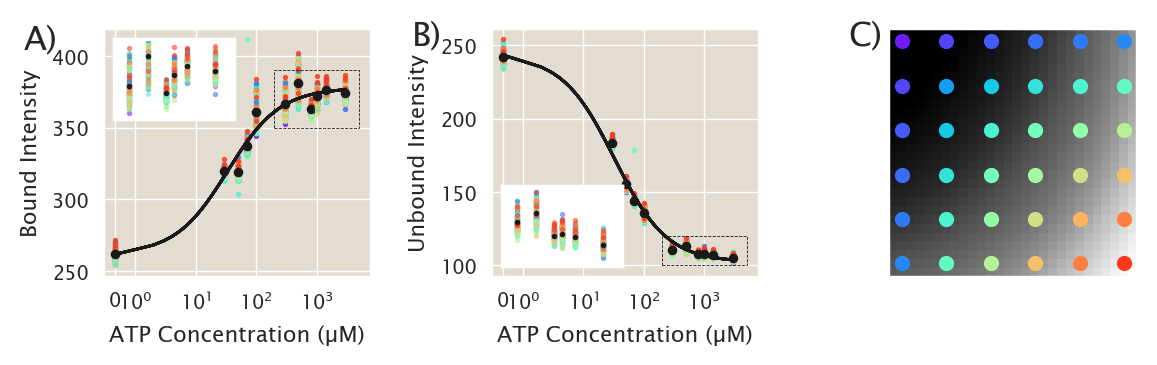

In [183]:
fig, ax = plt.subplots(1,3, figsize=(6, 2))

#colorbar settings
#normalize = mcolors.SymLogNorm(linthresh=5, vmin=ATPconc.min(), vmax=ATPconc.max())
normalize = mcolors.PowerNorm(0.5, vmin=0, vmax=ngridrows**2)
colormap = cm.rainbow
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(np.arange(ngridrows**2))

imvmin = np.mean(cent_means_alphas_unbound, axis=0).min()
imvmax = np.mean(cent_means_alphas_bound, axis=0).max()

#_____________________________________
ax[2].imshow(np.mean(cent_means_alphas_bound, axis=0), cmap=cm.Greys_r, vmin=imvmin, vmax=imvmax)
for i in samp_block_coord:
    for j in samp_block_coord:
        ax[2].scatter(i,j, color = colormap(normalize(i*j)), s=20)
ax[2].grid(False)

ax[2].xaxis.set_tick_params(labelbottom=False)
ax[2].yaxis.set_tick_params(labelleft=False)

#___________________________________
sub_ax0 = inset_axes(
            parent_axes=ax[0],
            width=0.6,
            height=0.4,
            loc='upper left',
            axes_kwargs={
                'facecolor': 'w'
            }
        )

sub_ax1 = inset_axes(
            parent_axes=ax[1],
            width=0.6,
            height=0.4,
            loc='lower left',
            axes_kwargs={
                'facecolor': 'w'
            }
        )

for atp in np.unique(ATPconc):
    demiis = np.where(ATPconc==atp)
    for i, i_px in enumerate(samp_block_coord):
        for j, j_px in enumerate(samp_block_coord):
            ax[0].scatter(atp*np.ones(len(demiis[0])), cent_means_ev_bound[demiis][:, i_px,j_px], color=colormap(normalize(i_px*j_px)),s=2, alpha=0.8, linewidths=0.5)
            sub_ax0.scatter(atp*np.ones(len(demiis[0])), cent_means_ev_bound[demiis][:, i_px,j_px], color=colormap(normalize(i_px*j_px)),s=2, alpha=0.5, linewidths=0.5)
            ax[1].scatter(atp*np.ones(len(demiis[0])), cent_means_ev_unbound[demiis][:, i_px,j_px], color=colormap(normalize(i_px*j_px)),s=2, alpha=0.8, linewidths=0.5)
            sub_ax1.scatter(atp*np.ones(len(demiis[0])), cent_means_ev_unbound[demiis][:, i_px,j_px], color=colormap(normalize(i_px*j_px)),s=2, alpha=0.5, linewidths=0.5)
        
    ax[0].scatter(atp, np.nanmean(cent_means_ev_bound[demiis]), c='k', s=6)
    sub_ax0.scatter(atp, np.nanmean(cent_means_ev_bound[demiis]), c='k', s=1)
    ax[0].plot(xfit_bound,yfit_bound, c='k', lw=1)
    ax[1].scatter(atp, np.nanmean(cent_means_ev_unbound[demiis]), c='k', s=6)
    sub_ax1.scatter(atp, np.nanmean(cent_means_ev_unbound[demiis]), c='k', s=1)
    ax[1].plot(xfit_unbound,yfit_unbound, c='k', lw=1)
ax[0].set_xscale('symlog',linthresh=1, linscale=0.3)
ax[1].set_xscale('symlog',linthresh=1, linscale=0.3)

sub_ax0.set_xlim(200, 5000)
sub_ax0.set_ylim(350, 390)
sub_ax0.set_xscale('symlog',linthresh=1, linscale=0.3)
sub_ax0.xaxis.set_tick_params(labelbottom=False)
sub_ax0.yaxis.set_tick_params(labelleft=False)

sub_ax1.set_xlim(200, 5000)
sub_ax1.set_ylim(100, 120)
sub_ax1.set_xscale('symlog',linthresh=1, linscale=0.3)
sub_ax1.xaxis.set_tick_params(labelbottom=False)
sub_ax1.yaxis.set_tick_params(labelleft=False)

ax[0].add_patch(plt.Rectangle((200,350), 5000-200, 390-350,
                                fill=False,
                                edgecolor='k',
                                lw=0.3,
                                ls='--'))
ax[1].add_patch(plt.Rectangle((200,100), 5000-80, 120-100,
                                fill=False,
                                edgecolor='k',
                                lw=0.3,
                                ls='--'))

ax[0].set_ylabel('Bound Intensity')
ax[0].set_xlabel('ATP Concentration (µM)')
ax[1].set_ylabel('Unbound Intensity')
ax[1].set_xlabel('ATP Concentration (µM)')

ax[0].text(-15, 405, 'A)')
ax[1].text(-15, 250, 'B)')
ax[2].text(-5, 1.5, 'C)')

# #fig, ax = plt.subplots(len(samp_block_coord),len(samp_block_coord),figsize=(20,20))
#         # create inset plot
#         sub_ax = inset_axes(
#             parent_axes=ax[i][j],
#             width=0.2,
#             height=0.2,
#             loc='lower left',
#             axes_kwargs={
#                 'facecolor': '#beface'
#             }
#         )
        
#         sub_ax.imshow(np.zeros_like(cent_means_alphas_bound[0]), cmap='Greys_r')
#         sub_ax.scatter(j_px, i_px, c='w', marker='s',s=2)
#         sub_ax.grid(False)
#         sub_ax.xaxis.set_tick_params(labelbottom=False)
#         sub_ax.yaxis.set_tick_params(labelleft=False)
#         sub_ax.patch.set_linewidth(0.1)


# #_____________________________________
# for i in samp_block_coord:
#     for j in samp_block_coord:
#         ax[0][2].hlines(np.mean(cent_means_alphas_bound[:, i,j]), 0, ATPconc.max(), color=colormap(normalize(i*j)), lw=0.2)
#         ax[1][2].hlines(np.mean(cent_means_alphas_unbound[:, i,j]), 0, ATPconc.max(), color=colormap(normalize(i*j)), lw=0.2)
#         for atp in np.unique(ATPconc):
#             demiis = np.where(ATPconc==atp)
#             ax[0][2].scatter(atp*np.ones(len(demiis[0])), cent_means_alphas_bound[demiis][:, i,j], color=colormap(normalize(i*j)), s=5)
#             ax[1][2].scatter(atp*np.ones(len(demiis[0])), cent_means_alphas_unbound[demiis][:, i,j], color=colormap(normalize(i*j)), s=5)
    
# ax[0][2].set_xscale('symlog',linthresh=1, linscale=0.3)
# ax[1][2].set_xscale('symlog',linthresh=1, linscale=0.3)
plt.tight_layout()
#plt.savefig('../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/Evened_blo_avgs', dpi=400)        


Object `ax.items` not found.


dict_items([('a)', <AxesSubplot:label='a)'>), ('c)', <AxesSubplot:label='c)'>), ('b)', <AxesSubplot:label='b)'>), ('d)', <AxesSubplot:label='d)'>)])


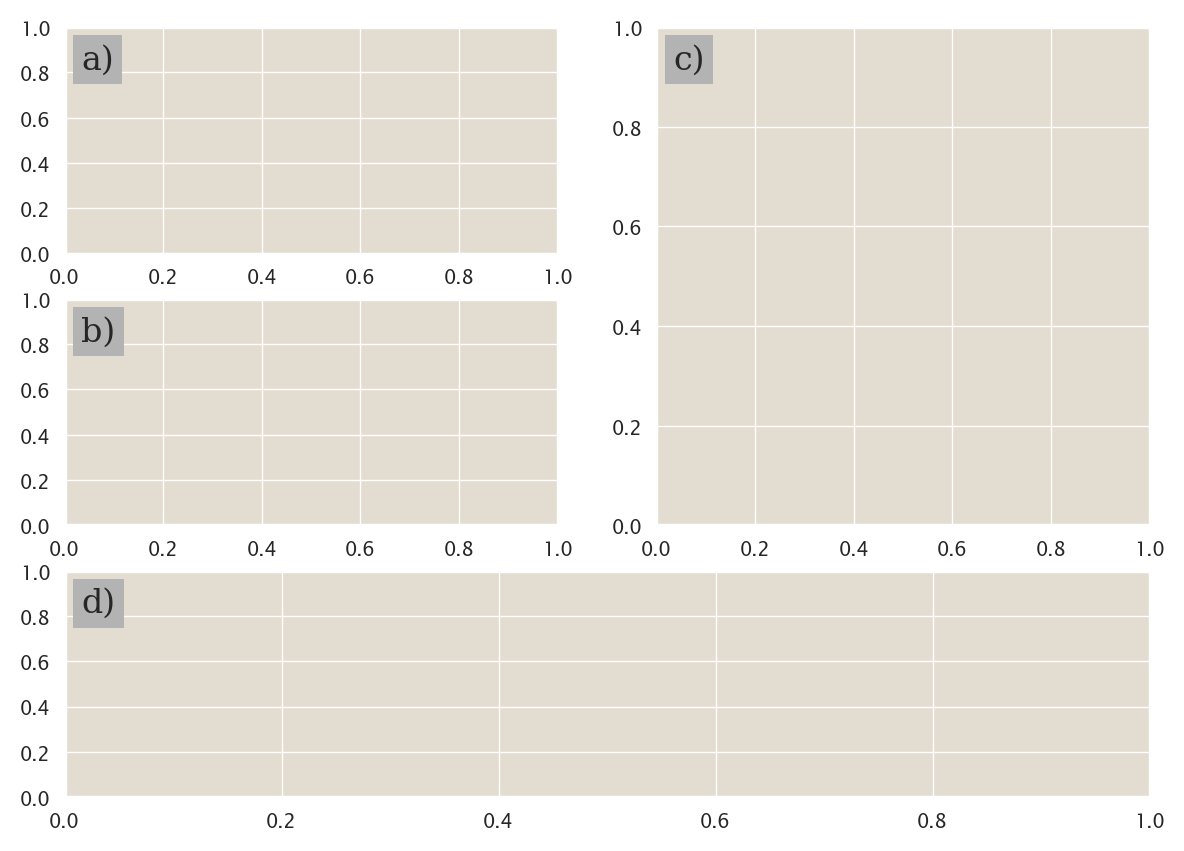

In [152]:
fig, axs = plt.subplot_mosaic([['a)', 'c)'], ['b)', 'c)'], ['d)', 'd)']])
for label, ax in axs.items():
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
    ax.annotate(
        label,
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    
print(axs.items())

In [ ]:
imvmin, imvmax

(0.785043186898194, 1.6842836710069706)

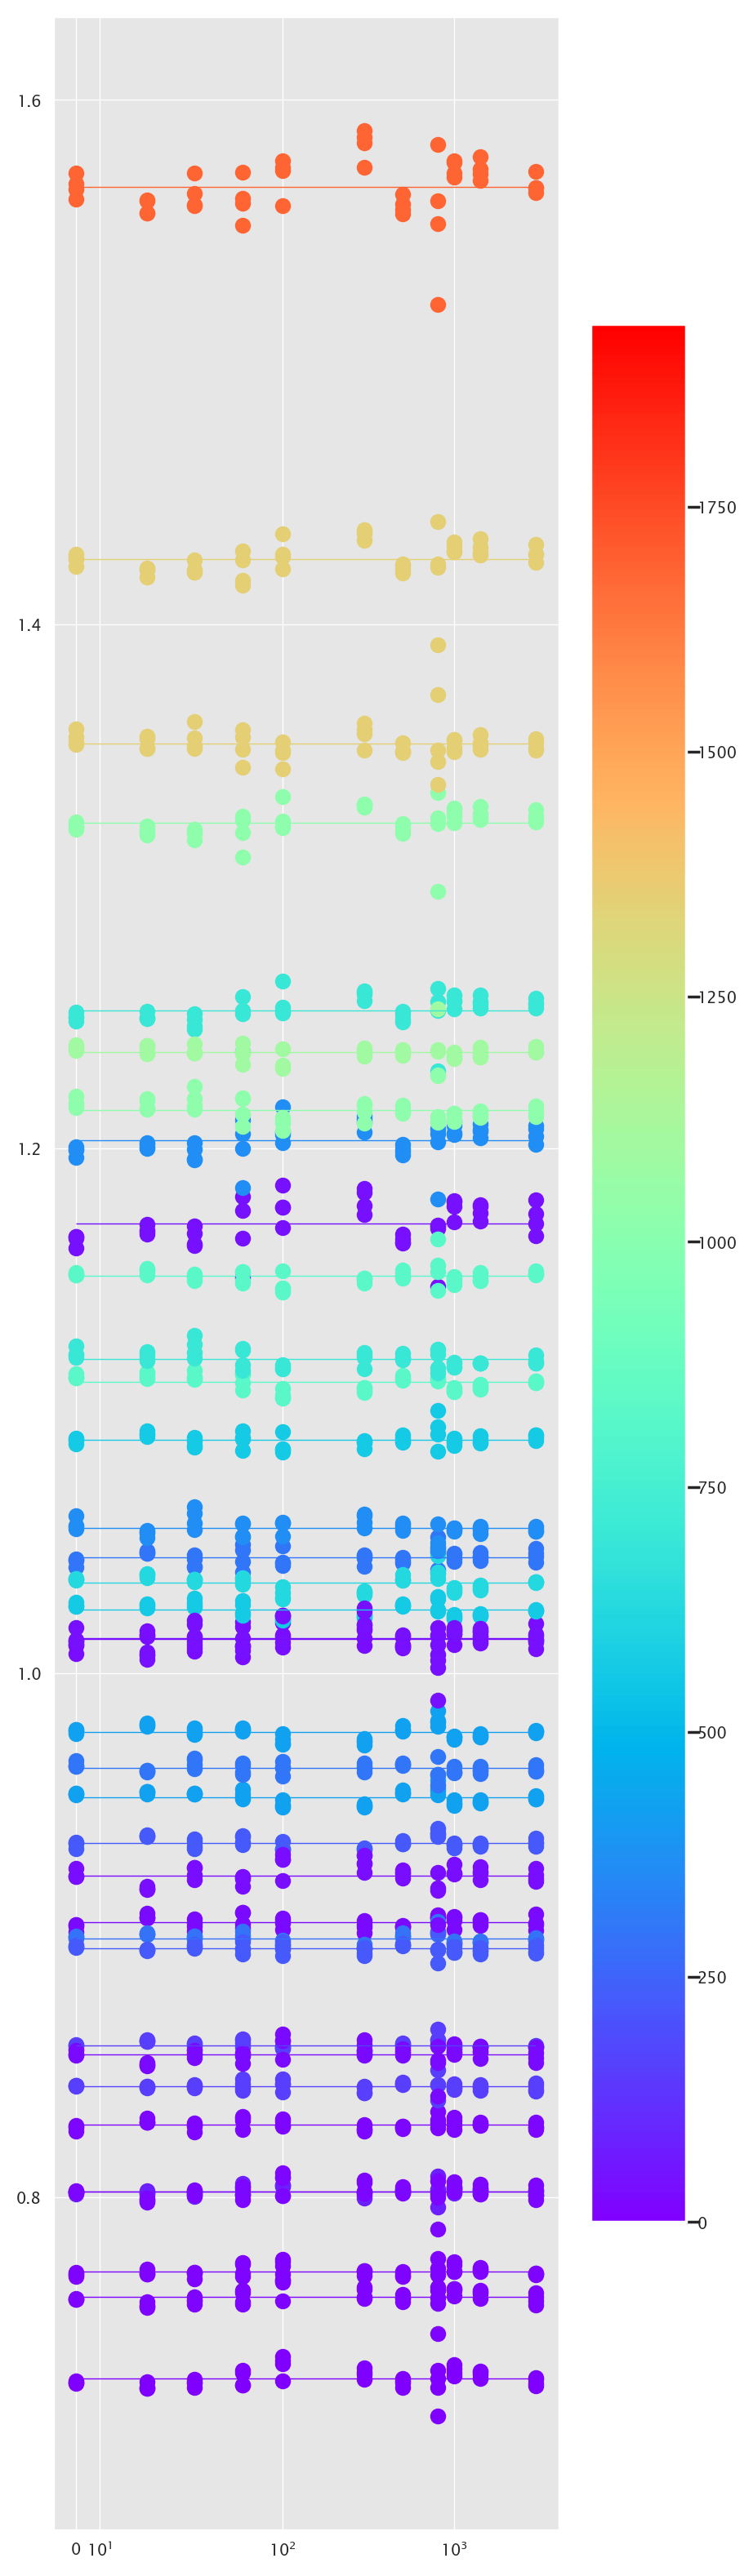

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,20))
 
# Setting the background color of the plot 
# using set_facecolor() method
ax.set_facecolor("#e6e6e6")
#colorbar settings
#normalize = mcolors.SymLogNorm(linthresh=5, vmin=ATPconc.min(), vmax=ATPconc.max())
normalize = mcolors.Normalize(vmin=0, vmax=ngridrows**2)
colormap = cm.rainbow
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(np.arange(ngridrows**2))


for i in samp_block_coord:
    for j in samp_block_coord:
        plt.hlines(np.mean(cent_means_alphas_bound[:, i,j]), 0, ATPconc.max(), color=colormap(normalize(i*j)), lw=0.5)
        for atp in np.unique(ATPconc):
            demiis = np.where(ATPconc==atp)
            plt.scatter(atp*np.ones(len(demiis[0])), cent_means_alphas_bound[demiis][:, i,j], color=colormap(normalize(i*j)))
            # plt.scatter(atp*np.ones(len(demiis[0])), cent_means_alphas[demiis][:, 20,20], c='r')
            # plt.scatter(atp*np.ones(len(demiis[0])), cent_means_alphas[demiis][:, 30,30], c='g')
plt.xscale('symlog',linthresh=80)
plt.colorbar(scalarmappable)


In [ ]:
fig, ax = plt.subplots(len(samp_block_coord),len(samp_block_coord),figsize=(20,20))
 
for i, i_px in enumerate(samp_block_coord):
    for j, j_px in enumerate(samp_block_coord):
        for atp in np.unique(ATPconc):
            demiis = np.where(ATPconc==atp)
            ax[i][j].scatter(atp*np.ones(len(demiis[0])), cent_means_ev_bound[demiis][:, i_px,j_px], color='g')
            ax[i][j].scatter(atp*np.ones(len(demiis[0])), cent_means_ev_unbound[demiis][:, i_px,j_px], color='orange')
        ax[i][j].plot(np.arange(ATPconc.max()), ATeam_Hill(np.arange(ATPconc.max()), samp_block_fits_bound[i,j,0], samp_block_fits_bound[i,j,1], samp_block_fits_bound[i,j,2]), c='g', lw=2)
        ax[i][j].plot(xfit_bound,yfit_bound, c='k', ls='--')
            
        ax[i][j].plot(np.arange(ATPconc.max()), ATeam_Hill(np.arange(ATPconc.max()), samp_block_fits_unbound[i,j,0], samp_block_fits_unbound[i,j,1], samp_block_fits_unbound[i,j,2]), c='orange', lw=2)
        ax[i][j].plot(xfit_unbound,yfit_unbound, c='k', ls='--')
        
        ax[i][j].set_xscale('symlog',linthresh=15)
        ax[i][j].set_ylim(50, 420)
        ax[i][j].xaxis.set_tick_params(labelbottom=False)
        ax[i][j].yaxis.set_tick_params(labelleft=False)
        ax[-1][j].xaxis.set_tick_params(labelbottom=True)
        ax[i][0].yaxis.set_tick_params(labelleft=True)
        #ax[i][j].set_title(f'mean {round(np.mean(cent_means_ev[:, i_px,j_px]),1)}, std {round(np.std(cent_means_ev[:, i_px,j_px]),3)}', fontsize=10)
        
#plt.colorbar(scalarmappable)

NameError: name 'samp_block_coord' is not defined

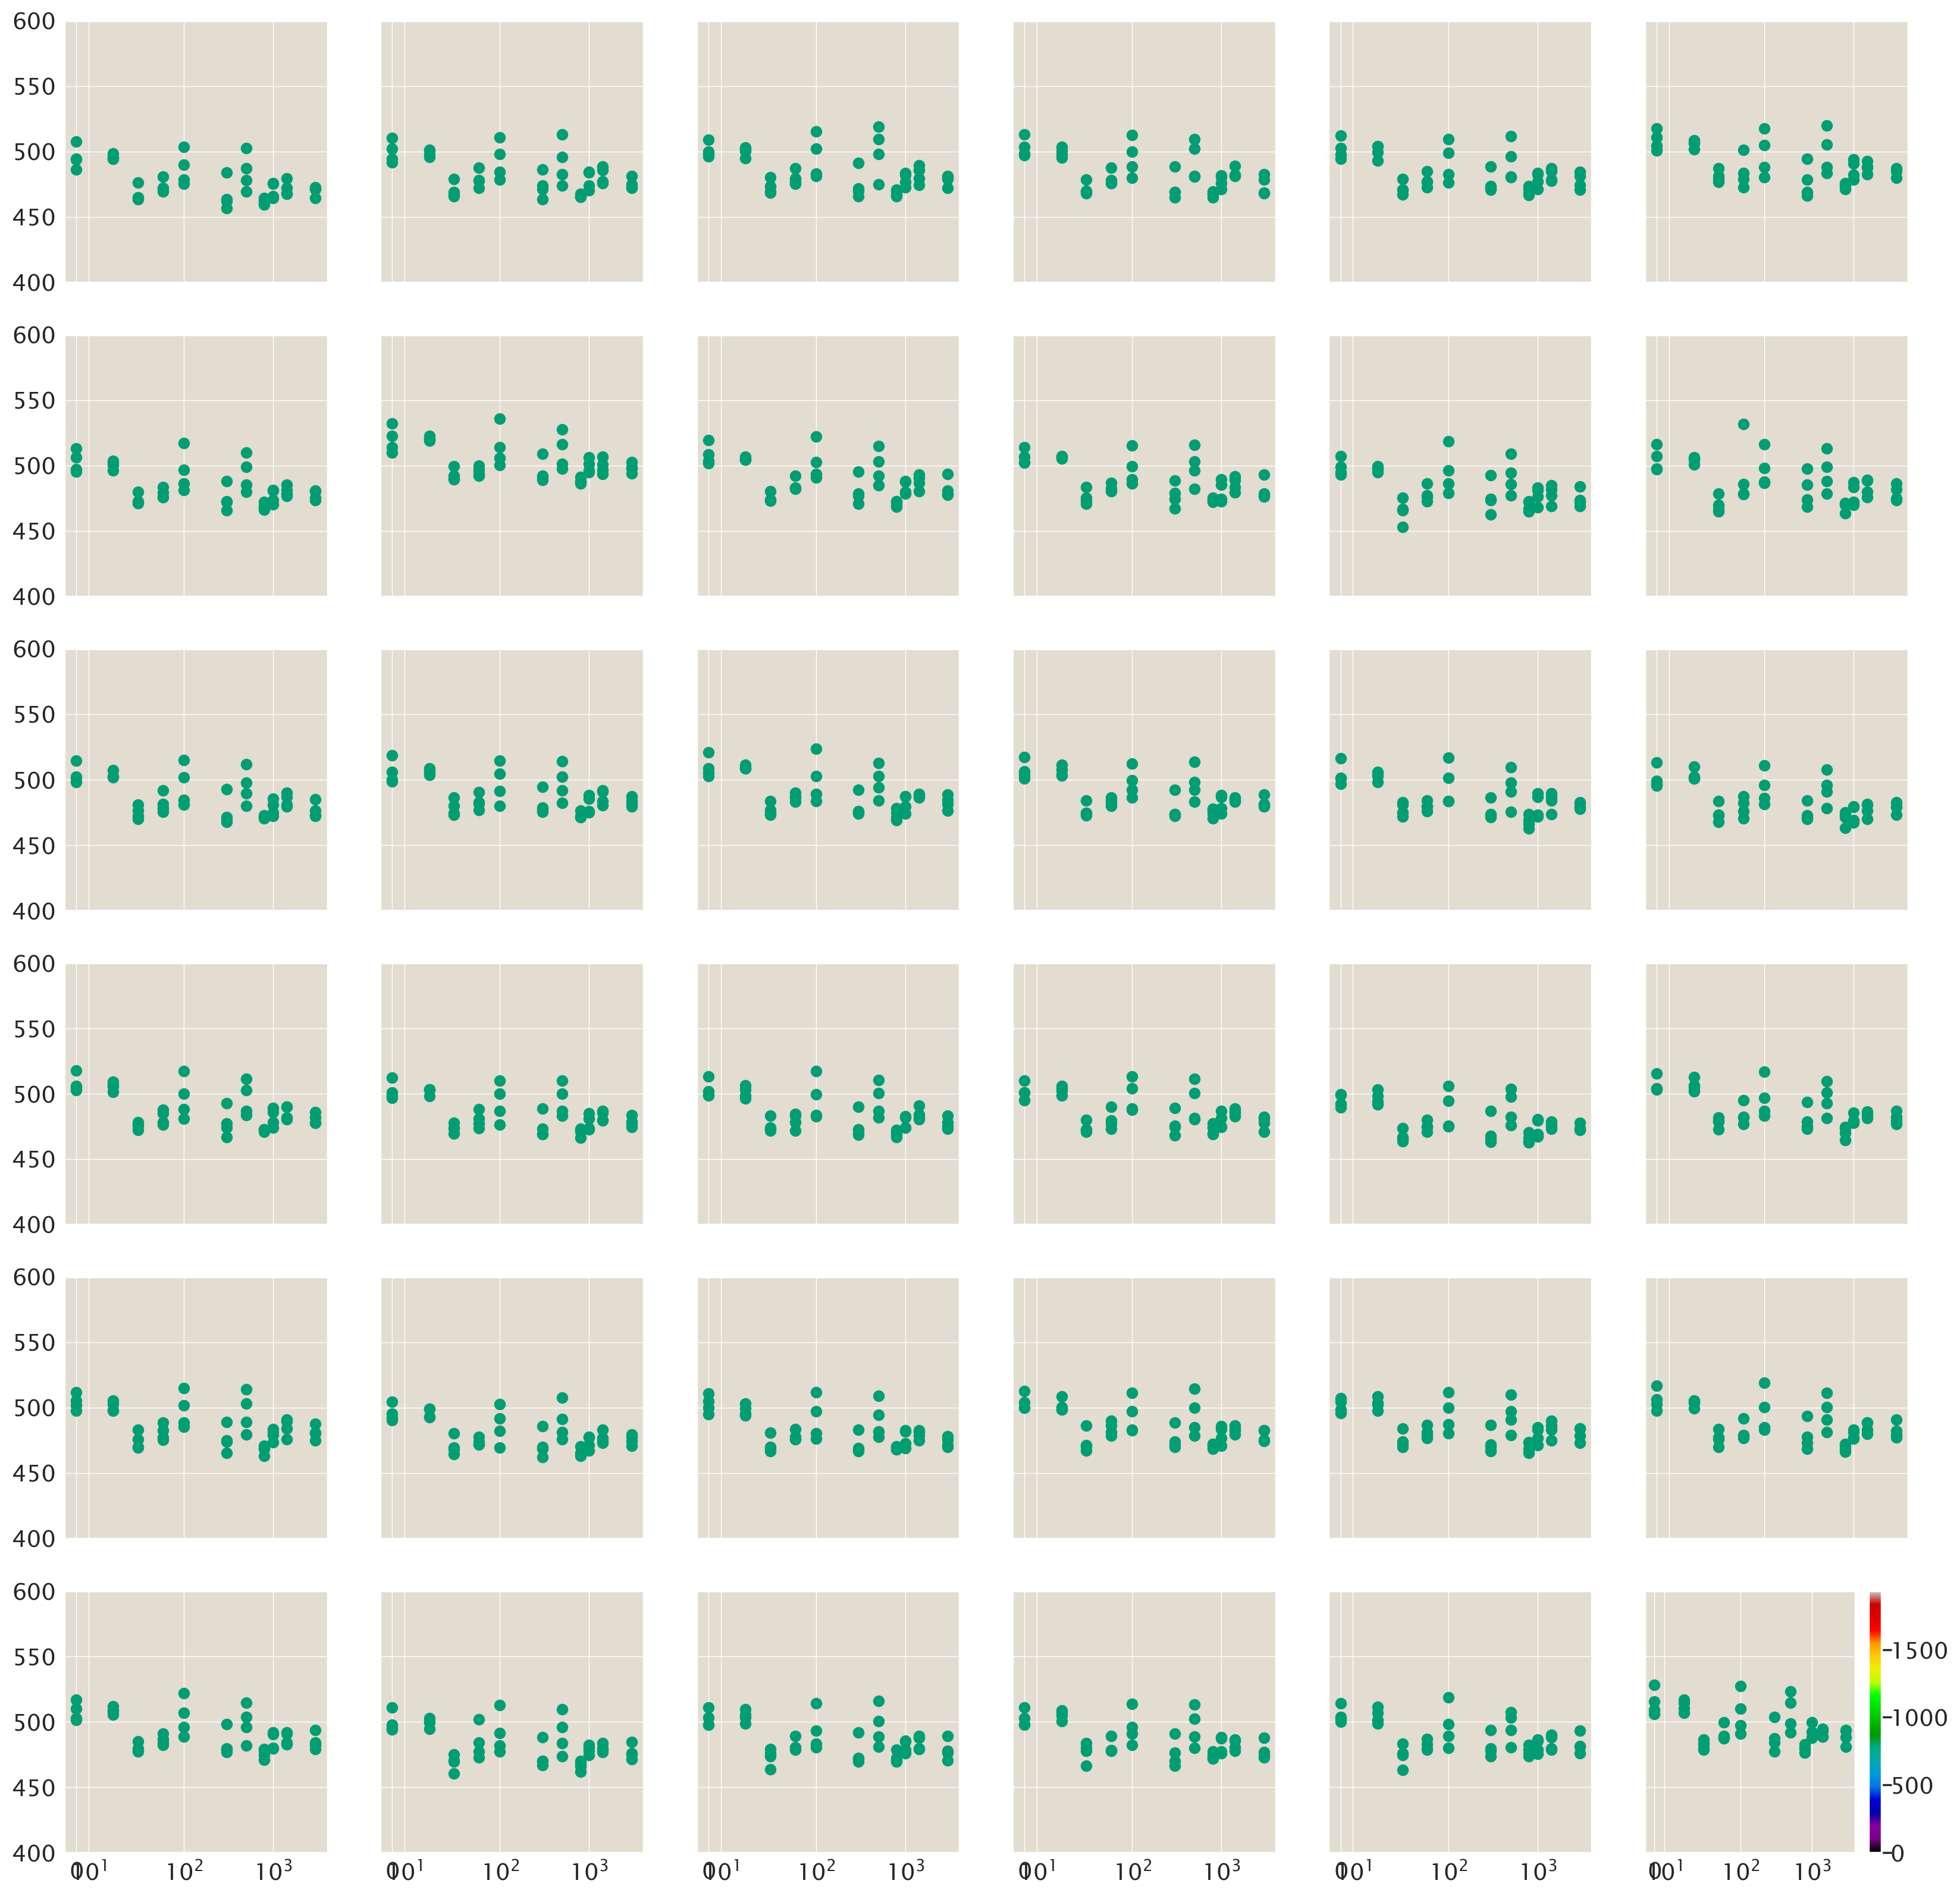

In [ ]:
fig, ax = plt.subplots(len(samp_block_coord),len(samp_block_coord),figsize=(20,20))
 
for i, i_px in enumerate(samp_block_coord):
    for j, j_px in enumerate(samp_block_coord):
        for atp in np.unique(ATPconc):
            demiis = np.where(ATPconc==atp)
            ax[i][j].scatter(atp*np.ones(len(demiis[0])), cent_means_ev_bound[demiis][:, i_px,j_px]+cent_means_ev_unbound[demiis][:, i_px,j_px], color='g')
            
        #ax[i][j].plot(xfit_bound,yfit_bound, c='k')
        #ax[i][j].plot(np.arange(ATPconc.max()), ATeam_Hill(np.arange(ATPconc.max()), samp_block_fits_bound[i,j,0], samp_block_fits_bound[i,j,1], samp_block_fits_bound[i,j,2]), c='g', lw=2)
        
        #ax[i][j].plot(xfit_unbound,yfit_unbound, c='k')
        #ax[i][j].plot(np.arange(ATPconc.max()), ATeam_Hill(np.arange(ATPconc.max()), samp_block_fits_unbound[i,j,0], samp_block_fits_unbound[i,j,1], samp_block_fits_unbound[i,j,2]), c='orange', lw=2)

        ax[i][j].set_xscale('symlog',linthresh=80)
        ax[i][j].set_ylim(400, 600)
        ax[i][j].xaxis.set_tick_params(labelbottom=False)
        ax[i][j].yaxis.set_tick_params(labelleft=False)
        ax[-1][j].xaxis.set_tick_params(labelbottom=True)
        ax[i][0].yaxis.set_tick_params(labelleft=True)
        #ax[i][j].set_title(f'mean {round(np.mean(cent_means_ev[:, i_px,j_px]),1)}, std {round(np.std(cent_means_ev[:, i_px,j_px]),3)}', fontsize=10)


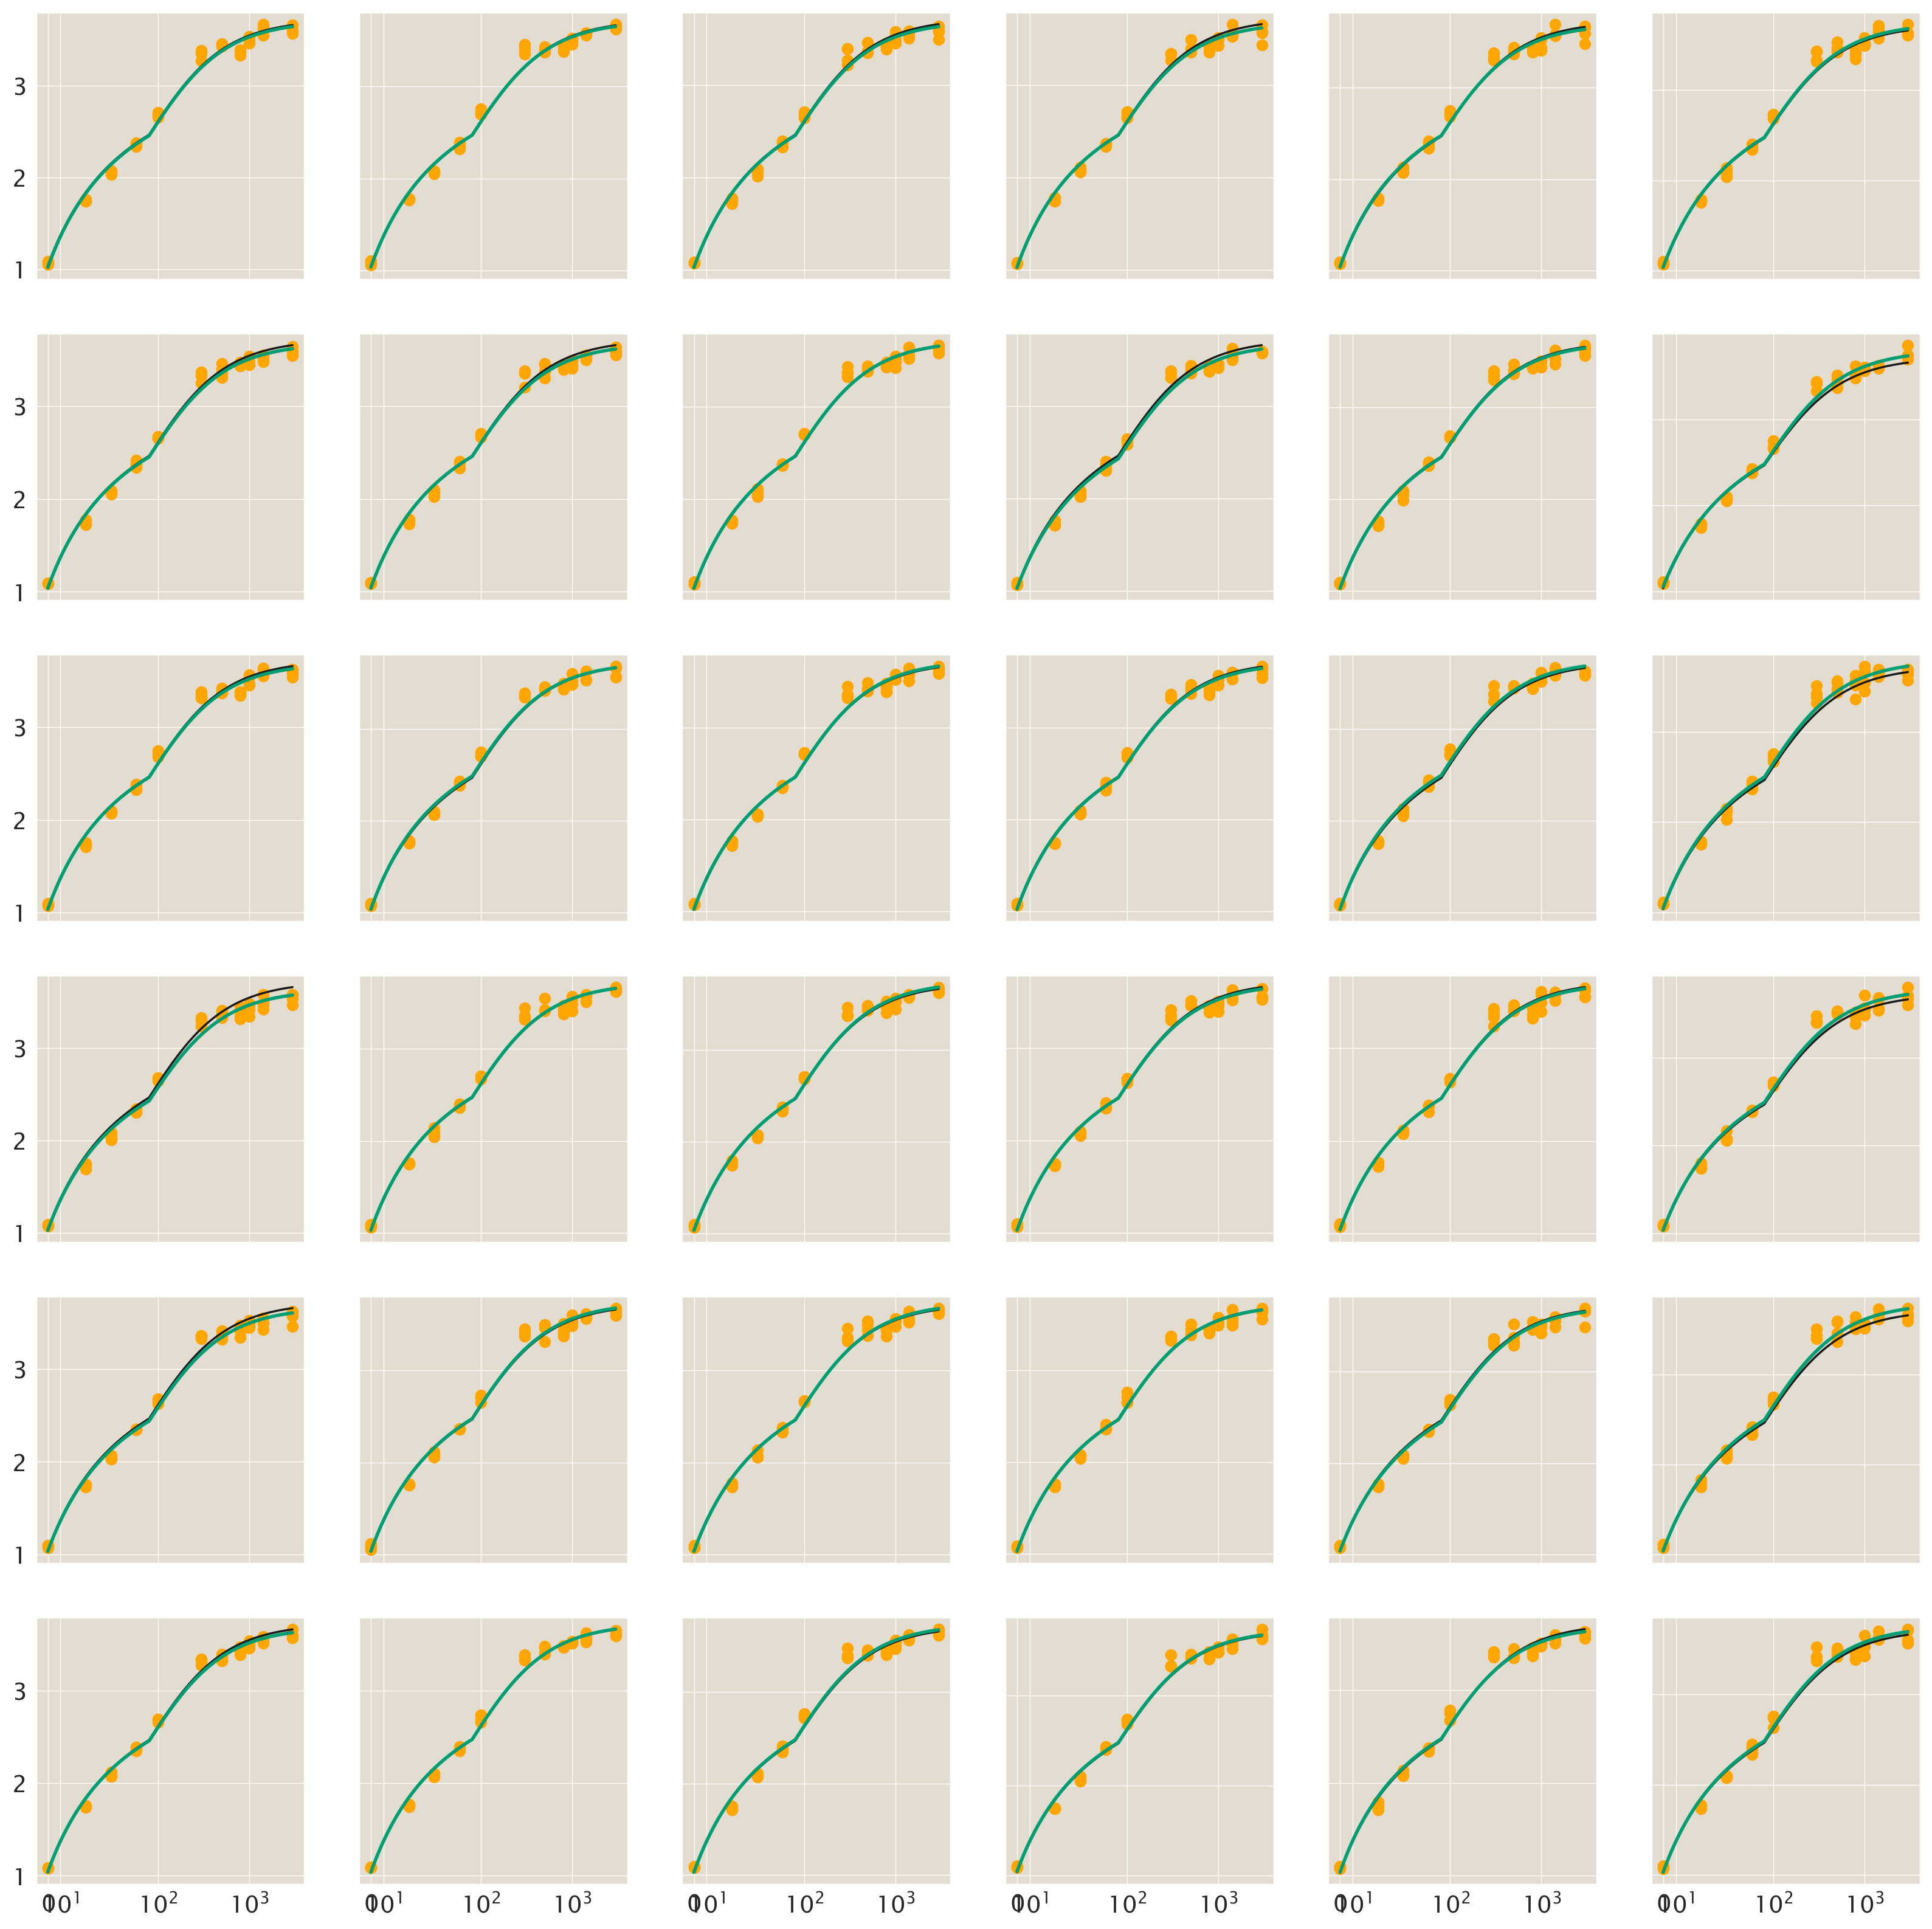

In [ ]:
fig, ax = plt.subplots(len(samp_block_coord),len(samp_block_coord),figsize=(20,20))
 
for i, i_px in enumerate(samp_block_coord):
    for j, j_px in enumerate(samp_block_coord):
        for atp in np.unique(ATPconc):
            demiis = np.where(ATPconc==atp)
            ax[i][j].scatter(atp*np.ones(len(demiis[0])), cent_means_ev_ratio[demiis][:, i_px,j_px], color='orange')
        ax[i][j].plot(xfit_ratio,yfit_ratio, c='k')
        ax[i][j].plot(np.arange(ATPconc.max()), ATeam_Hill(np.arange(ATPconc.max()), samp_block_fits_ratio[i,j,0], samp_block_fits_ratio[i,j,1], samp_block_fits_ratio[i,j,2]), c='g', lw=2)
        
        ax[i][j].set_xscale('symlog',linthresh=80)
        #ax[i][j].set_ylim(50, 420)
        ax[i][j].xaxis.set_tick_params(labelbottom=False)
        ax[i][j].yaxis.set_tick_params(labelleft=False)
        ax[-1][j].xaxis.set_tick_params(labelbottom=True)
        ax[i][0].yaxis.set_tick_params(labelleft=True)
        #ax[i][j].set_title(f'mean {round(np.mean(cent_means_ev[:, i_px,j_px]),1)}, std {round(np.std(cent_means_ev[:, i_px,j_px]),3)}', fontsize=10)
        
#plt.colorbar(scalarmappable)